# 🎯 Gradient-Based Optimization: From Mechanics to Mastery

---

## What This Notebook Will Teach You

By the end of this notebook, you will:

1. **Understand the mechanics** — What exactly happens in each update step
2. **Visualize the landscape** — Why some problems are easy and others are hard
3. **Know the optimizer zoo** — SGD, Momentum, Adam, AdamW and when to use each
4. **Make informed decisions** — A practical framework for choosing optimizers

---

### 📚 Table of Contents

| Module | Topic | Key Question Answered |
|--------|-------|----------------------|
| 1 | The Mechanics of Gradient Descent | *What actually happens in each step?* |
| 2 | The Landscape Determines Everything | *Why does GD succeed or fail?* |
| 3 | Hyperparameter Deep Dive | *How does learning rate affect behavior?* |
| 4 | Batch, Mini-batch, and Stochastic GD | *What's the difference and why does it matter?* |
| 5 | Advanced Optimizers | *How do Momentum, Adam, etc. actually work?* |
| 6 | Head-to-Head Comparisons | *Which optimizer wins on which problem?* |
| 7 | Decision Framework | *What should I use for MY problem?* |
| 8 | Learning Rate Schedules | *How do I tune LR during training?* |

---

In [1]:
# ============================================================
# SETUP: Import libraries and configure plotting
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Reproducibility
np.random.seed(42)

print("✅ Setup complete!")

✅ Setup complete!


---

# Module 1: The Mechanics of Gradient Descent

---

## 1.1 The Core Idea: What Is a Gradient?

Before we optimize anything, we need to understand what a **gradient** actually is.

### The Gradient Is a Vector of Partial Derivatives

For a function $L(\theta_1, \theta_2, ..., \theta_n)$, the gradient is:

$$\nabla L = \begin{bmatrix} \frac{\partial L}{\partial \theta_1} \\ \frac{\partial L}{\partial \theta_2} \\ \vdots \\ \frac{\partial L}{\partial \theta_n} \end{bmatrix}$$

### Key Properties of the Gradient

| Property | What It Means |
|----------|---------------|
| **Direction** | Points toward steepest *increase* of the function |
| **Magnitude** | How steep the slope is at that point |
| **Negative gradient** | Points toward steepest *decrease* (what we want!) |

Let's visualize this with a simple 2D function:

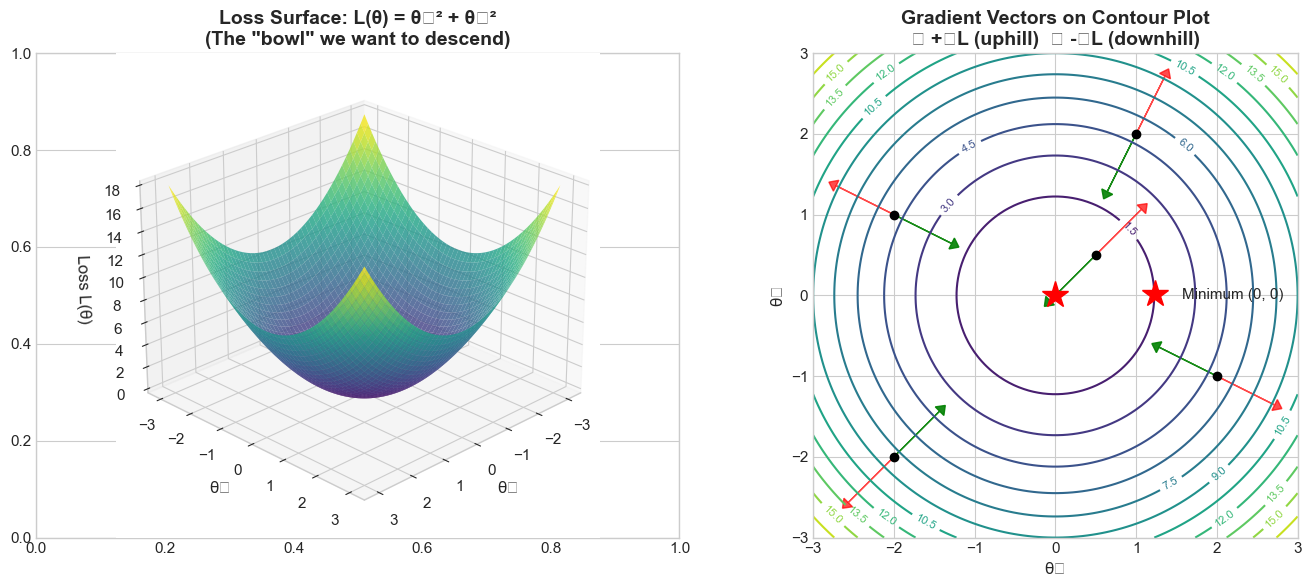


📌 KEY INSIGHT:
   The NEGATIVE gradient always points toward lower values of the loss.
   This is why we SUBTRACT the gradient in the update rule!


In [2]:
# ============================================================
# VISUALIZATION: What is a gradient?
# ============================================================

def simple_quadratic(x, y):
    """Simple bowl: f(x,y) = x² + y²"""
    return x**2 + y**2

def gradient_quadratic(x, y):
    """Gradient: [2x, 2y]"""
    return np.array([2*x, 2*y])

# Create grid
x_range = np.linspace(-3, 3, 100)
y_range = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = simple_quadratic(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: 3D surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.set_xlabel('θ₁')
ax1.set_ylabel('θ₂')
ax1.set_zlabel('Loss L(θ)')
ax1.set_title('Loss Surface: L(θ) = θ₁² + θ₂²\n(The "bowl" we want to descend)', fontweight='bold')
ax1.view_init(elev=25, azim=45)

# Right: Contour with gradient vectors
ax2 = axes[1]
contour = ax2.contour(X, Y, Z, levels=15, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)

# Sample points to show gradient vectors
sample_points = [(-2, -2), (-2, 1), (1, 2), (2, -1), (0.5, 0.5)]

for (px, py) in sample_points:
    grad = gradient_quadratic(px, py)
    # Normalize for visibility (scale factor)
    grad_norm = grad / (np.linalg.norm(grad) + 1e-8) * 0.8
    
    # Positive gradient (red) - direction of steepest INCREASE
    ax2.arrow(px, py, grad_norm[0], grad_norm[1], 
              head_width=0.15, head_length=0.1, fc='red', ec='red', alpha=0.7)
    
    # Negative gradient (green) - direction of steepest DECREASE
    ax2.arrow(px, py, -grad_norm[0], -grad_norm[1], 
              head_width=0.15, head_length=0.1, fc='green', ec='green', alpha=0.9)
    
    ax2.plot(px, py, 'ko', markersize=6)

ax2.plot(0, 0, 'r*', markersize=20, label='Minimum (0, 0)')
ax2.set_xlabel('θ₁')
ax2.set_ylabel('θ₂')
ax2.set_title('Gradient Vectors on Contour Plot\n🔴 +∇L (uphill)  🟢 -∇L (downhill)', fontweight='bold')
ax2.set_aspect('equal')
ax2.legend()

plt.tight_layout()
plt.show()

print("")
print("📌 KEY INSIGHT:")
print("   The NEGATIVE gradient always points toward lower values of the loss.")
print("   This is why we SUBTRACT the gradient in the update rule!")

---

## 1.2 The Update Rule — Dissected

The heart of gradient descent is this single equation:

$$\Large \boxed{\theta_{\text{new}} = \theta_{\text{old}} - \alpha \cdot \nabla L(\theta_{\text{old}})}$$

Let's break down **every component**:

| Symbol | Name | What It Is | Role |
|--------|------|------------|------|
| $\theta$ | Parameters | The values we're optimizing (weights, biases) | What we update |
| $L(\theta)$ | Loss function | Measures how bad our current parameters are | What we minimize |
| $\nabla L$ | Gradient | Vector of partial derivatives | Direction of steepest increase |
| $\alpha$ | Learning rate | Step size (hyperparameter) | How far we move |
| $-$ | Minus sign | We go *opposite* to gradient | Descend, not ascend! |

### Why the Minus Sign?

- The gradient $\nabla L$ points **uphill** (toward higher loss)
- We want to go **downhill** (toward lower loss)
- So we move in the **opposite** direction: $-\nabla L$

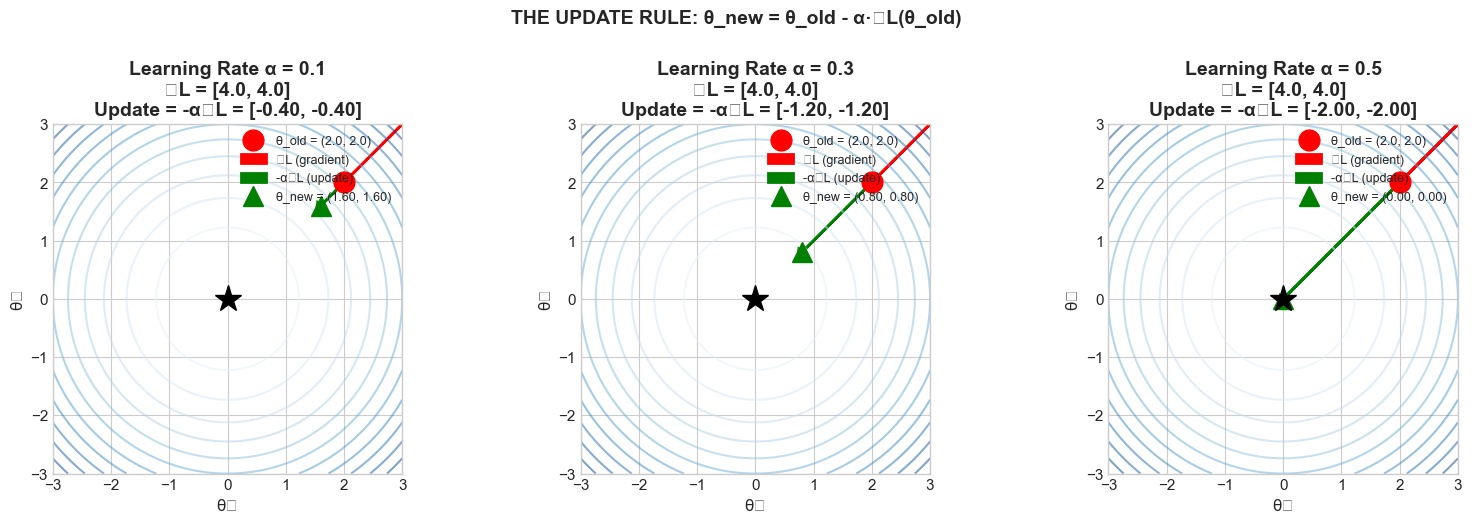


📌 OBSERVATION:
   Larger learning rate → Bigger step toward minimum
   But be careful: too large can OVERSHOOT the minimum!


In [3]:
# ============================================================
# VISUALIZATION: The update rule in action
# ============================================================

def visualize_single_update(theta_old, learning_rate, ax):
    """Show one gradient descent step visually"""
    
    # Compute gradient at current position
    grad = gradient_quadratic(theta_old[0], theta_old[1])
    
    # Compute new position
    theta_new = theta_old - learning_rate * grad
    
    # Draw contours
    contour = ax.contour(X, Y, Z, levels=15, cmap='Blues', alpha=0.5)
    
    # Mark old position
    ax.plot(theta_old[0], theta_old[1], 'ro', markersize=15, label=f'θ_old = ({theta_old[0]:.1f}, {theta_old[1]:.1f})')
    
    # Draw gradient vector (red, pointing uphill)
    scale = 0.3
    ax.arrow(theta_old[0], theta_old[1], grad[0]*scale, grad[1]*scale,
             head_width=0.15, head_length=0.1, fc='red', ec='red', linewidth=2, label='∇L (gradient)')
    
    # Draw update vector (green, pointing downhill)
    update = -learning_rate * grad
    ax.arrow(theta_old[0], theta_old[1], update[0], update[1],
             head_width=0.15, head_length=0.1, fc='green', ec='green', linewidth=2, label='-α∇L (update)')
    
    # Mark new position
    ax.plot(theta_new[0], theta_new[1], 'g^', markersize=15, label=f'θ_new = ({theta_new[0]:.2f}, {theta_new[1]:.2f})')
    
    # Mark minimum
    ax.plot(0, 0, 'k*', markersize=20)
    
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_aspect('equal')
    ax.legend(loc='upper right', fontsize=9)
    
    return theta_new, grad

# Show the update with different learning rates
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

theta_start = np.array([2.0, 2.0])
learning_rates = [0.1, 0.3, 0.5]

for ax, lr in zip(axes, learning_rates):
    theta_new, grad = visualize_single_update(theta_start, lr, ax)
    ax.set_xlabel('θ₁')
    ax.set_ylabel('θ₂')
    ax.set_title(f'Learning Rate α = {lr}\n'
                 f'∇L = [{grad[0]:.1f}, {grad[1]:.1f}]\n'
                 f'Update = -α∇L = [{-lr*grad[0]:.2f}, {-lr*grad[1]:.2f}]', 
                 fontweight='bold')

plt.suptitle('THE UPDATE RULE: θ_new = θ_old - α·∇L(θ_old)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("")
print("📌 OBSERVATION:")
print("   Larger learning rate → Bigger step toward minimum")
print("   But be careful: too large can OVERSHOOT the minimum!")

---

## 1.3 Step-by-Step Manual Example

Let's walk through gradient descent **by hand** to truly internalize the mechanics.

### Problem Setup

- **Function to minimize:** $L(\theta_1, \theta_2) = \theta_1^2 + \theta_2^2$
- **Gradient:** $\nabla L = [2\theta_1, 2\theta_2]$
- **Starting point:** $\theta^{(0)} = [2.0, 2.0]$
- **Learning rate:** $\alpha = 0.1$
- **Minimum:** At $(0, 0)$ with $L = 0$

### Let's Calculate Each Step

In [4]:
# ============================================================
# MANUAL WALKTHROUGH: 5 iterations by hand
# ============================================================

print("="*80)
print("MANUAL GRADIENT DESCENT WALKTHROUGH")
print("="*80)
print(f"\nFunction: L(θ₁, θ₂) = θ₁² + θ₂²")
print(f"Gradient: ∇L = [2θ₁, 2θ₂]")
print(f"Learning rate: α = 0.1")
print(f"Starting point: θ⁽⁰⁾ = [2.0, 2.0]")
print("\n" + "-"*80)

# Initialize
theta = np.array([2.0, 2.0])
alpha = 0.1
history = [theta.copy()]

print("\n📝 STEP-BY-STEP CALCULATIONS:\n")

for i in range(5):
    # Current state
    loss = simple_quadratic(theta[0], theta[1])
    grad = gradient_quadratic(theta[0], theta[1])
    
    print(f"┌─ Iteration {i} ─────────────────────────────────────────────────┐")
    print(f"│                                                                 │")
    print(f"│  Current θ = [{theta[0]:.4f}, {theta[1]:.4f}]                          │")
    print(f"│  Loss L(θ) = {theta[0]:.4f}² + {theta[1]:.4f}² = {loss:.4f}                    │")
    print(f"│                                                                 │")
    print(f"│  Gradient ∇L = [2×{theta[0]:.4f}, 2×{theta[1]:.4f}] = [{grad[0]:.4f}, {grad[1]:.4f}]  │")
    print(f"│                                                                 │")
    print(f"│  Update: θ_new = θ_old - α·∇L                                   │")
    print(f"│        = [{theta[0]:.4f}, {theta[1]:.4f}] - 0.1×[{grad[0]:.4f}, {grad[1]:.4f}]  │")
    print(f"│        = [{theta[0]:.4f}, {theta[1]:.4f}] - [{alpha*grad[0]:.4f}, {alpha*grad[1]:.4f}]      │")
    
    # Perform update
    theta = theta - alpha * grad
    history.append(theta.copy())
    
    print(f"│        = [{theta[0]:.4f}, {theta[1]:.4f}]                              │")
    print(f"│                                                                 │")
    print(f"└─────────────────────────────────────────────────────────────────┘")
    print()

history = np.array(history)

print("\n" + "="*80)
print("SUMMARY: Convergence Progress")
print("="*80)
print(f"\n{'Iteration':<12} {'θ₁':<12} {'θ₂':<12} {'Loss':<12} {'Distance to Min':<15}")
print("-"*60)
for i, theta in enumerate(history):
    loss = simple_quadratic(theta[0], theta[1])
    dist = np.sqrt(theta[0]**2 + theta[1]**2)
    print(f"{i:<12} {theta[0]:<12.4f} {theta[1]:<12.4f} {loss:<12.4f} {dist:<15.4f}")

MANUAL GRADIENT DESCENT WALKTHROUGH

Function: L(θ₁, θ₂) = θ₁² + θ₂²
Gradient: ∇L = [2θ₁, 2θ₂]
Learning rate: α = 0.1
Starting point: θ⁽⁰⁾ = [2.0, 2.0]

--------------------------------------------------------------------------------

📝 STEP-BY-STEP CALCULATIONS:

┌─ Iteration 0 ─────────────────────────────────────────────────┐
│                                                                 │
│  Current θ = [2.0000, 2.0000]                          │
│  Loss L(θ) = 2.0000² + 2.0000² = 8.0000                    │
│                                                                 │
│  Gradient ∇L = [2×2.0000, 2×2.0000] = [4.0000, 4.0000]  │
│                                                                 │
│  Update: θ_new = θ_old - α·∇L                                   │
│        = [2.0000, 2.0000] - 0.1×[4.0000, 4.0000]  │
│        = [2.0000, 2.0000] - [0.4000, 0.4000]      │
│        = [1.6000, 1.6000]                              │
│                                               

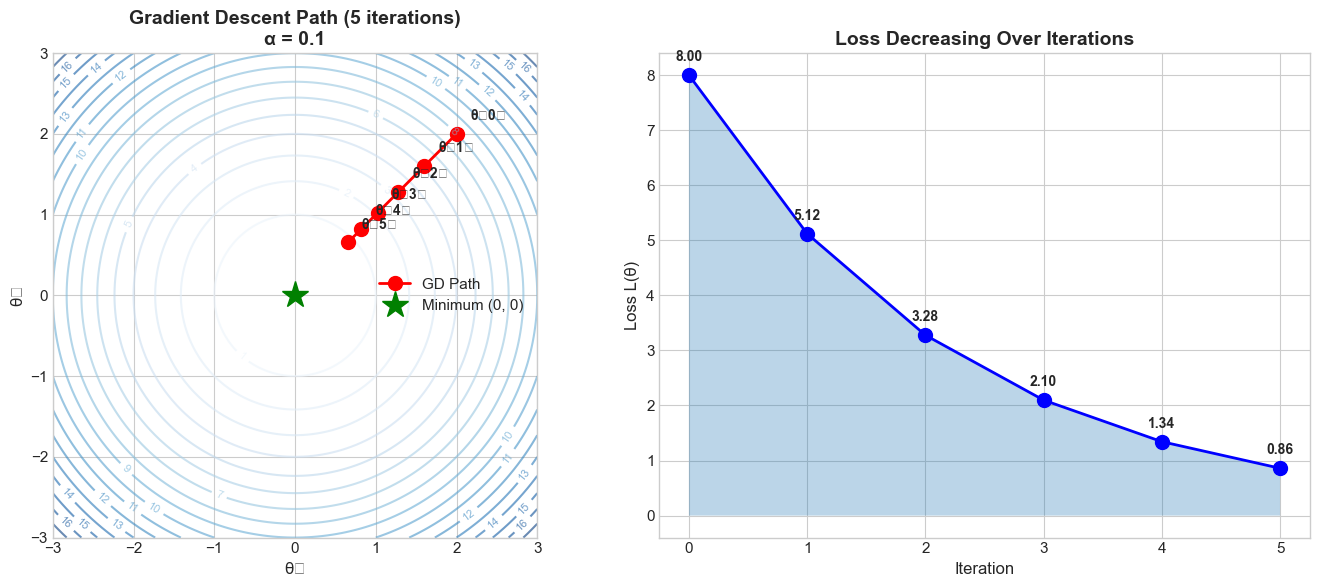


📌 KEY INSIGHT:
   Each step reduces the loss! The gradient always points us in the right direction.
   After just 5 iterations: Loss dropped from 8.00 → 0.86 (89.3% reduction)


In [5]:
# ============================================================
# VISUALIZATION: The manual walkthrough path
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Path on contour plot
ax1 = axes[0]
contour = ax1.contour(X, Y, Z, levels=20, cmap='Blues', alpha=0.6)
ax1.clabel(contour, inline=True, fontsize=8)

# Plot path
ax1.plot(history[:, 0], history[:, 1], 'o-', color='red', linewidth=2, markersize=10, label='GD Path')

# Label each point
for i, (x, y) in enumerate(history):
    ax1.annotate(f'θ⁽{i}⁾', (x, y), xytext=(10, 10), textcoords='offset points', fontsize=10, fontweight='bold')

ax1.plot(0, 0, 'g*', markersize=20, label='Minimum (0, 0)')
ax1.set_xlabel('θ₁')
ax1.set_ylabel('θ₂')
ax1.set_title('Gradient Descent Path (5 iterations)\nα = 0.1', fontweight='bold')
ax1.legend()
ax1.set_aspect('equal')

# Right: Loss over iterations
ax2 = axes[1]
losses = [simple_quadratic(t[0], t[1]) for t in history]
ax2.plot(range(len(losses)), losses, 'o-', color='blue', linewidth=2, markersize=10)
ax2.fill_between(range(len(losses)), losses, alpha=0.3)

for i, loss in enumerate(losses):
    ax2.annotate(f'{loss:.2f}', (i, loss), xytext=(0, 10), textcoords='offset points', 
                 ha='center', fontsize=10, fontweight='bold')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss L(θ)')
ax2.set_title('Loss Decreasing Over Iterations', fontweight='bold')
ax2.set_xticks(range(len(losses)))

plt.tight_layout()
plt.show()

print("\n📌 KEY INSIGHT:")
print("   Each step reduces the loss! The gradient always points us in the right direction.")
print(f"   After just 5 iterations: Loss dropped from {losses[0]:.2f} → {losses[-1]:.2f} ({(1-losses[-1]/losses[0])*100:.1f}% reduction)")

---

## 1.4 Geometric Interpretation: Following the Contours

The **contour lines** are lines of equal loss. Gradient descent is perpendicular to these contours because the gradient is always perpendicular to level sets.

Think of it like water flowing downhill — it always takes the steepest path.

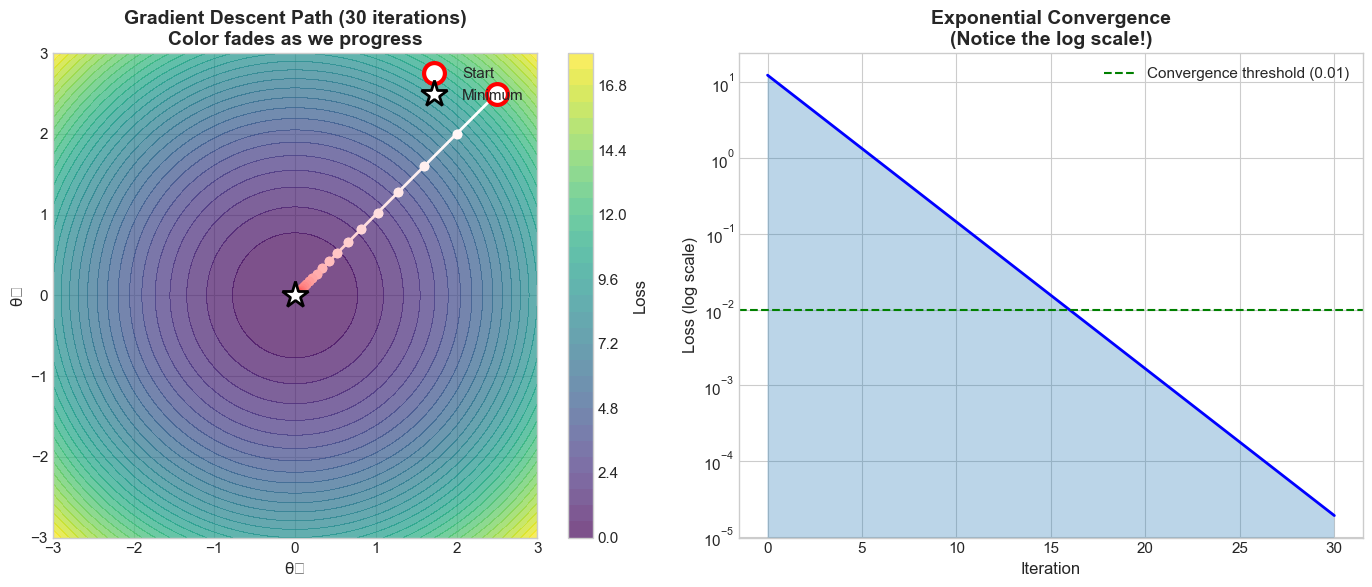


📊 CONVERGENCE STATISTICS:
   Start loss:  12.5000
   Final loss:  0.000019
   Reduction:   99.9998%
   Final θ:     [0.003095, 0.003095]


In [6]:
# ============================================================
# VISUALIZATION: Full gradient descent run with many iterations
# ============================================================

def run_gradient_descent(start, loss_fn, grad_fn, lr, n_iters):
    """Run gradient descent and return history"""
    theta = np.array(start, dtype=float)
    history = [theta.copy()]
    losses = [loss_fn(theta[0], theta[1])]
    
    for _ in range(n_iters):
        grad = grad_fn(theta[0], theta[1])
        theta = theta - lr * grad
        history.append(theta.copy())
        losses.append(loss_fn(theta[0], theta[1]))
    
    return np.array(history), np.array(losses)

# Run with more iterations
history_full, losses_full = run_gradient_descent(
    start=[2.5, 2.5],
    loss_fn=simple_quadratic,
    grad_fn=gradient_quadratic,
    lr=0.1,
    n_iters=30
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Path visualization
ax1 = axes[0]
contour = ax1.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.7)
plt.colorbar(contour, ax=ax1, label='Loss')

# Draw path with color gradient showing progression
for i in range(len(history_full) - 1):
    color_intensity = 1 - i / len(history_full)
    ax1.plot(history_full[i:i+2, 0], history_full[i:i+2, 1], 
             'o-', color=(1, color_intensity, color_intensity), 
             linewidth=2, markersize=6)

ax1.plot(history_full[0, 0], history_full[0, 1], 'wo', markersize=15, 
         markeredgecolor='red', markeredgewidth=3, label='Start')
ax1.plot(0, 0, 'w*', markersize=20, markeredgecolor='black', markeredgewidth=2, label='Minimum')
ax1.set_xlabel('θ₁')
ax1.set_ylabel('θ₂')
ax1.set_title('Gradient Descent Path (30 iterations)\nColor fades as we progress', fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_aspect('equal')

# Right: Loss curve
ax2 = axes[1]
ax2.semilogy(losses_full, 'b-', linewidth=2)
ax2.fill_between(range(len(losses_full)), losses_full, alpha=0.3)
ax2.axhline(y=0.01, color='g', linestyle='--', label='Convergence threshold (0.01)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss (log scale)')
ax2.set_title('Exponential Convergence\n(Notice the log scale!)', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n📊 CONVERGENCE STATISTICS:")
print(f"   Start loss:  {losses_full[0]:.4f}")
print(f"   Final loss:  {losses_full[-1]:.6f}")
print(f"   Reduction:   {(1-losses_full[-1]/losses_full[0])*100:.4f}%")
print(f"   Final θ:     [{history_full[-1, 0]:.6f}, {history_full[-1, 1]:.6f}]")

---

## 📝 Module 1 Summary

### Key Takeaways

| Concept | What You Learned |
|---------|------------------|
| **Gradient** | A vector pointing toward steepest *increase* |
| **Negative gradient** | Points toward steepest *decrease* (what we follow) |
| **Update rule** | $\theta_{new} = \theta_{old} - \alpha \cdot \nabla L$ |
| **Learning rate** | Controls step size; too small = slow, too big = unstable |
| **Convergence** | On convex problems, GD reliably finds the minimum |

### The Recipe

```
1. Start at some initial θ
2. Compute gradient ∇L at current θ
3. Take a step: θ = θ - α·∇L
4. Repeat until loss stops decreasing
```

---

---

# Module 2: The Landscape Determines Everything

---

In Module 1, gradient descent worked perfectly. But that was on an **ideal** surface (a smooth bowl).

Real-world loss surfaces are rarely this nice. The **geometry of the loss landscape** determines whether GD succeeds or fails.

## 2.1 Convex vs Non-Convex: The Fundamental Divide

| Property | Convex | Non-Convex |
|----------|--------|------------|
| **Shape** | Single bowl | Mountains, valleys, plateaus |
| **Local minima** | Only one (global) | Many possible |
| **GD guarantee** | Always finds global min | May get stuck in local min |
| **Examples** | Linear regression MSE | Neural network loss |

### Visual Definition of Convexity

A function is **convex** if a line segment between any two points on the surface lies **above or on** the surface.

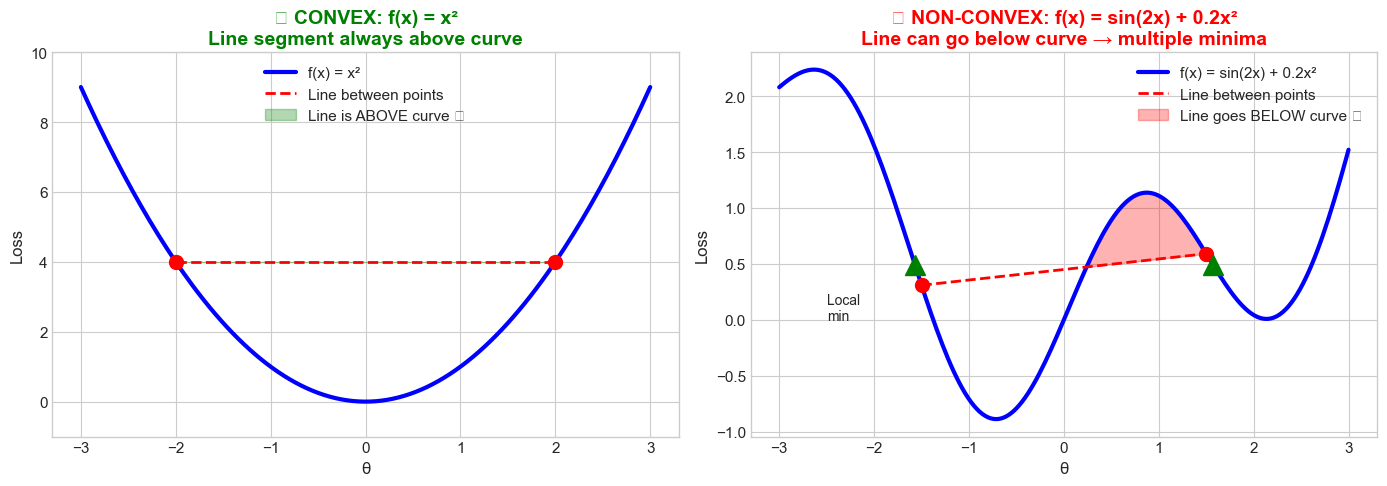


📌 KEY INSIGHT:
   CONVEX: One minimum, GD always finds it
   NON-CONVEX: Multiple minima, GD may get stuck in a bad one!


In [7]:
# ============================================================
# VISUALIZATION: Convex vs Non-Convex
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.linspace(-3, 3, 200)

# Convex function
ax1 = axes[0]
y_convex = x**2
ax1.plot(x, y_convex, 'b-', linewidth=3, label='f(x) = x²')

# Show line segment between two points
x1, x2 = -2, 2
y1, y2 = x1**2, x2**2
ax1.plot([x1, x2], [y1, y2], 'r--', linewidth=2, label='Line between points')
ax1.plot([x1, x2], [y1, y2], 'ro', markersize=10)
ax1.fill_between([x1, x2], [y1, y2], [x1**2 for _ in [x1, x2]], alpha=0.3, color='green', 
                  label='Line is ABOVE curve ✓')

ax1.set_xlabel('θ')
ax1.set_ylabel('Loss')
ax1.set_title('✅ CONVEX: f(x) = x²\nLine segment always above curve', fontweight='bold', color='green')
ax1.legend()
ax1.set_ylim(-1, 10)

# Non-convex function
ax2 = axes[1]
y_nonconvex = np.sin(2*x) + 0.2*x**2
ax2.plot(x, y_nonconvex, 'b-', linewidth=3, label='f(x) = sin(2x) + 0.2x²')

# Show line segment that goes BELOW the curve
x1, x2 = -1.5, 1.5
y1, y2 = np.sin(2*x1) + 0.2*x1**2, np.sin(2*x2) + 0.2*x2**2
ax2.plot([x1, x2], [y1, y2], 'r--', linewidth=2, label='Line between points')
ax2.plot([x1, x2], [y1, y2], 'ro', markersize=10)

# Shade region where line is below curve
x_segment = np.linspace(x1, x2, 100)
y_line = y1 + (y2-y1)/(x2-x1) * (x_segment - x1)
y_curve = np.sin(2*x_segment) + 0.2*x_segment**2
ax2.fill_between(x_segment, y_line, y_curve, where=(y_line < y_curve), 
                  alpha=0.3, color='red', label='Line goes BELOW curve ✗')

# Mark local minima
local_mins = [-1.57, 1.57]
for lm in local_mins:
    ax2.plot(lm, np.sin(2*lm) + 0.2*lm**2, 'g^', markersize=15)
ax2.annotate('Local\nmin', (-1.57, np.sin(-3.14) + 0.2*1.57**2), xytext=(-2.5, 0), fontsize=10)

ax2.set_xlabel('θ')
ax2.set_ylabel('Loss')
ax2.set_title('❌ NON-CONVEX: f(x) = sin(2x) + 0.2x²\nLine can go below curve → multiple minima', 
              fontweight='bold', color='red')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📌 KEY INSIGHT:")
print("   CONVEX: One minimum, GD always finds it")
print("   NON-CONVEX: Multiple minima, GD may get stuck in a bad one!")

---

## 2.2 Why Linear Regression is Convex (and Neural Networks Are Not)

This is a **critical** concept that determines whether vanilla GD will work.

### Linear Regression: MSE Loss is Convex

For linear regression: $\hat{y} = \theta_0 + \theta_1 x$

The MSE loss: $L = \frac{1}{n}\sum(y_i - \theta_0 - \theta_1 x_i)^2$

This is a **quadratic** in the parameters → Always convex!

### Neural Network: Non-Linear Activation Breaks Convexity

For a neural network: $\hat{y} = w_2 \cdot \sigma(w_1 x + b_1) + b_2$

The sigmoid $\sigma$ is non-linear → Loss becomes non-convex!

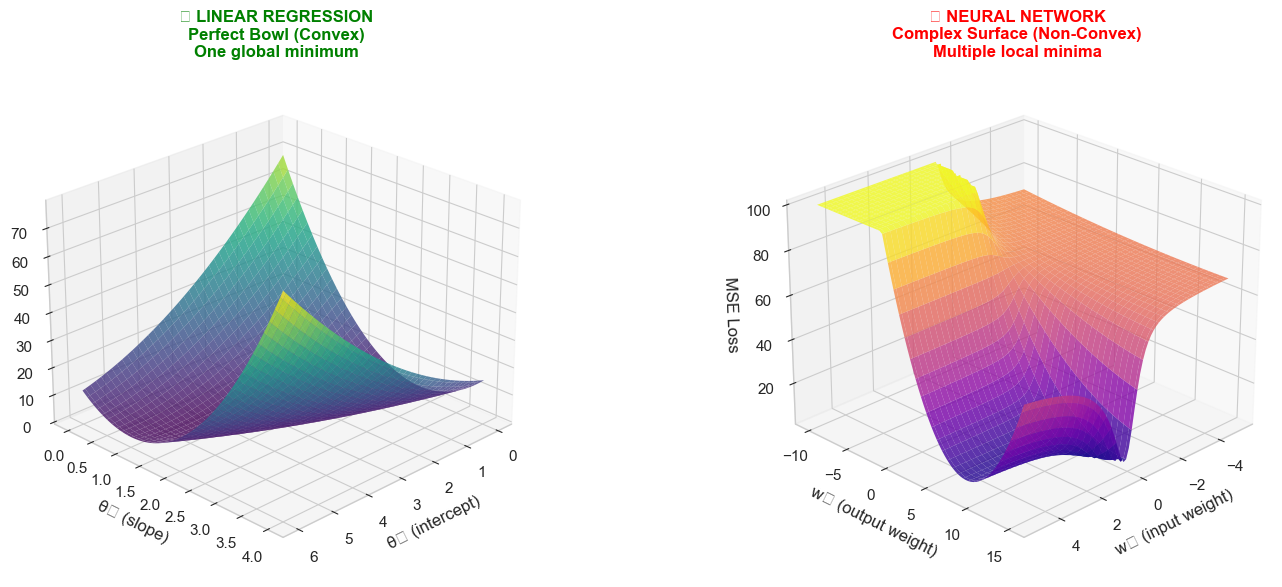

In [8]:
# ============================================================
# VISUALIZATION: Linear Regression vs Neural Network Loss Surfaces
# ============================================================

# Generate simple data
np.random.seed(42)
x_data = np.linspace(0, 5, 50)
y_data = 3 + 2*x_data + np.random.normal(0, 1, 50)

def mse_linear(theta0, theta1):
    """MSE for linear regression"""
    pred = theta0 + theta1 * x_data
    return np.mean((y_data - pred)**2)

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def mse_neural(w1, w2, b1=0, b2=0):
    """MSE for simple neural network"""
    hidden = sigmoid(w1 * x_data + b1)
    pred = w2 * hidden + b2
    return np.mean((y_data - pred)**2)

# Create grids
t0_range = np.linspace(0, 6, 80)
t1_range = np.linspace(0, 4, 80)
T0, T1 = np.meshgrid(t0_range, t1_range)

w1_range = np.linspace(-5, 5, 80)
w2_range = np.linspace(-10, 15, 80)
W1, W2 = np.meshgrid(w1_range, w2_range)

# Compute losses
Z_linear = np.zeros_like(T0)
Z_neural = np.zeros_like(W1)

for i in range(len(t0_range)):
    for j in range(len(t1_range)):
        Z_linear[j, i] = mse_linear(t0_range[i], t1_range[j])

for i in range(len(w1_range)):
    for j in range(len(w2_range)):
        Z_neural[j, i] = mse_neural(w1_range[i], w2_range[j])

# Clip for visualization
Z_neural = np.clip(Z_neural, 0, 100)

fig = plt.figure(figsize=(16, 6))

# Linear regression - 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T0, T1, Z_linear, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.set_xlabel('θ₀ (intercept)')
ax1.set_ylabel('θ₁ (slope)')
ax1.set_zlabel('MSE Loss')
ax1.set_title('✅ LINEAR REGRESSION\nPerfect Bowl (Convex)\nOne global minimum', 
              fontweight='bold', color='green', fontsize=12)
ax1.view_init(elev=25, azim=45)

# Neural network - 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(W1, W2, Z_neural, cmap='plasma', alpha=0.8, edgecolor='none')
ax2.set_xlabel('w₁ (input weight)')
ax2.set_ylabel('w₂ (output weight)')
ax2.set_zlabel('MSE Loss')
ax2.set_title('❌ NEURAL NETWORK\nComplex Surface (Non-Convex)\nMultiple local minima', 
              fontweight='bold', color='red', fontsize=12)
ax2.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

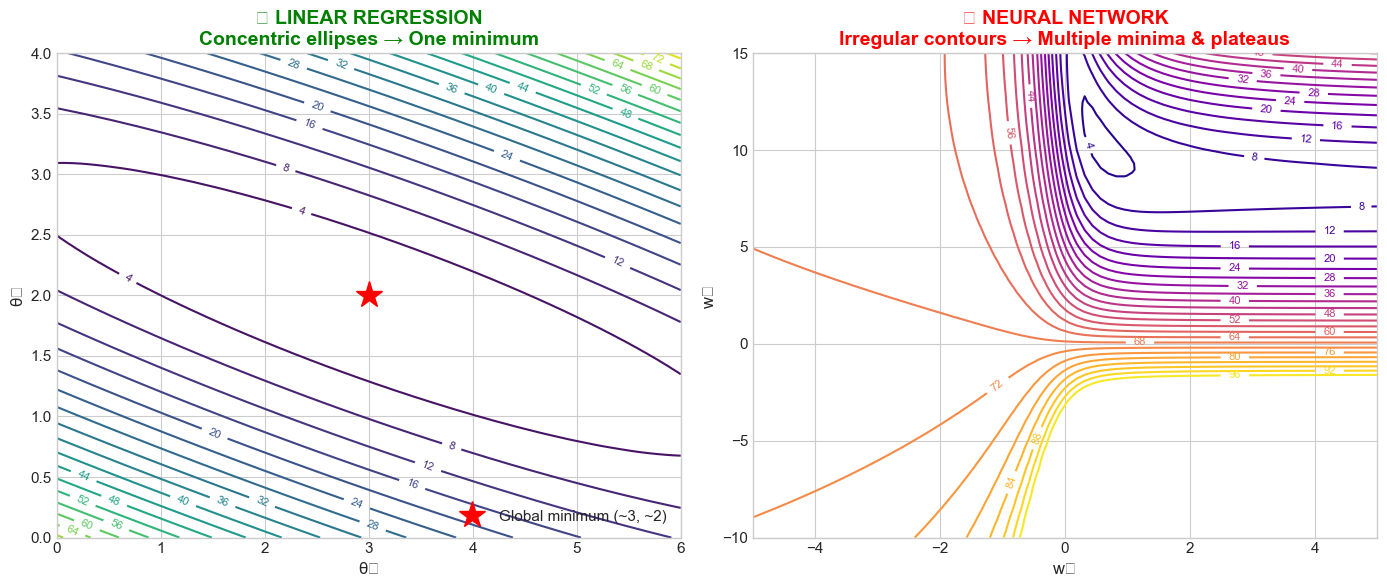


WHY IS THIS?

LINEAR REGRESSION:
   Loss = Σ(y - θ₀ - θ₁x)²

   This is QUADRATIC in θ₀ and θ₁ (no powers higher than 2)
   → The Hessian is positive semi-definite
   → CONVEX (perfect bowl)
   → GD ALWAYS finds the global minimum

NEURAL NETWORK:
   Loss = Σ(y - w₂·σ(w₁·x))²

   The sigmoid σ is NON-LINEAR
   → Parameters interact in complex ways (w₁ affects σ, which affects w₂'s effect)
   → NOT CONVEX (valleys, ridges, saddles)
   → GD may get stuck in local minima!



In [9]:
# ============================================================
# VISUALIZATION: Contour comparison
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear regression contours
ax1 = axes[0]
contour1 = ax1.contour(T0, T1, Z_linear, levels=20, cmap='viridis')
ax1.clabel(contour1, inline=True, fontsize=8)
ax1.plot(3, 2, 'r*', markersize=20, label='Global minimum (~3, ~2)')
ax1.set_xlabel('θ₀')
ax1.set_ylabel('θ₁')
ax1.set_title('✅ LINEAR REGRESSION\nConcentric ellipses → One minimum', fontweight='bold', color='green')
ax1.legend()

# Neural network contours
ax2 = axes[1]
contour2 = ax2.contour(W1, W2, Z_neural, levels=30, cmap='plasma')
ax2.clabel(contour2, inline=True, fontsize=8)
ax2.set_xlabel('w₁')
ax2.set_ylabel('w₂')
ax2.set_title('❌ NEURAL NETWORK\nIrregular contours → Multiple minima & plateaus', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("WHY IS THIS?")
print("="*80)
print("""
LINEAR REGRESSION:
   Loss = Σ(y - θ₀ - θ₁x)²
   
   This is QUADRATIC in θ₀ and θ₁ (no powers higher than 2)
   → The Hessian is positive semi-definite
   → CONVEX (perfect bowl)
   → GD ALWAYS finds the global minimum

NEURAL NETWORK:
   Loss = Σ(y - w₂·σ(w₁·x))²
   
   The sigmoid σ is NON-LINEAR
   → Parameters interact in complex ways (w₁ affects σ, which affects w₂'s effect)
   → NOT CONVEX (valleys, ridges, saddles)
   → GD may get stuck in local minima!
""")

---

## 2.3 Pathological Geometries: Where GD Struggles

Beyond convexity, several **geometric features** make optimization difficult.

| Problem | Description | Visual | GD Behavior |
|---------|-------------|--------|-------------|
| **Ill-conditioning** | Different curvatures in different directions | Elongated ellipse | Oscillates, slow progress |
| **Narrow valleys** | Long, curved ravines | Banana shape | Zig-zags along valley |
| **Multiple minima** | Many local optima | Many holes | Gets stuck in bad ones |
| **Saddle points** | Flat in some directions | Horse saddle | Gets stuck, slow escape |
| **Plateaus** | Very flat regions | Table top | Near-zero gradient, stuck |

Let's visualize each one:

In [10]:
# ============================================================
# DEFINE PATHOLOGICAL FUNCTIONS
# ============================================================

def ill_conditioned(x, y, ratio=50):
    """Elongated bowl - different curvatures"""
    return x**2 / ratio + y**2

def ill_conditioned_grad(x, y, ratio=50):
    return np.array([2*x/ratio, 2*y])

def rosenbrock(x, y):
    """Rosenbrock function - narrow curved valley"""
    return (1 - x)**2 + 100*(y - x**2)**2

def rosenbrock_grad(x, y):
    dx = -2*(1-x) - 400*x*(y - x**2)
    dy = 200*(y - x**2)
    return np.array([dx, dy])

def rastrigin(x, y):
    """Rastrigin function - many local minima"""
    A = 10
    return A*2 + (x**2 - A*np.cos(2*np.pi*x)) + (y**2 - A*np.cos(2*np.pi*y))

def rastrigin_grad(x, y):
    A = 10
    dx = 2*x + A*2*np.pi*np.sin(2*np.pi*x)
    dy = 2*y + A*2*np.pi*np.sin(2*np.pi*y)
    return np.array([dx, dy])

def saddle(x, y):
    """Saddle point function"""
    return x**2 - y**2

def saddle_grad(x, y):
    return np.array([2*x, -2*y])

print("✅ Pathological functions defined!")

✅ Pathological functions defined!


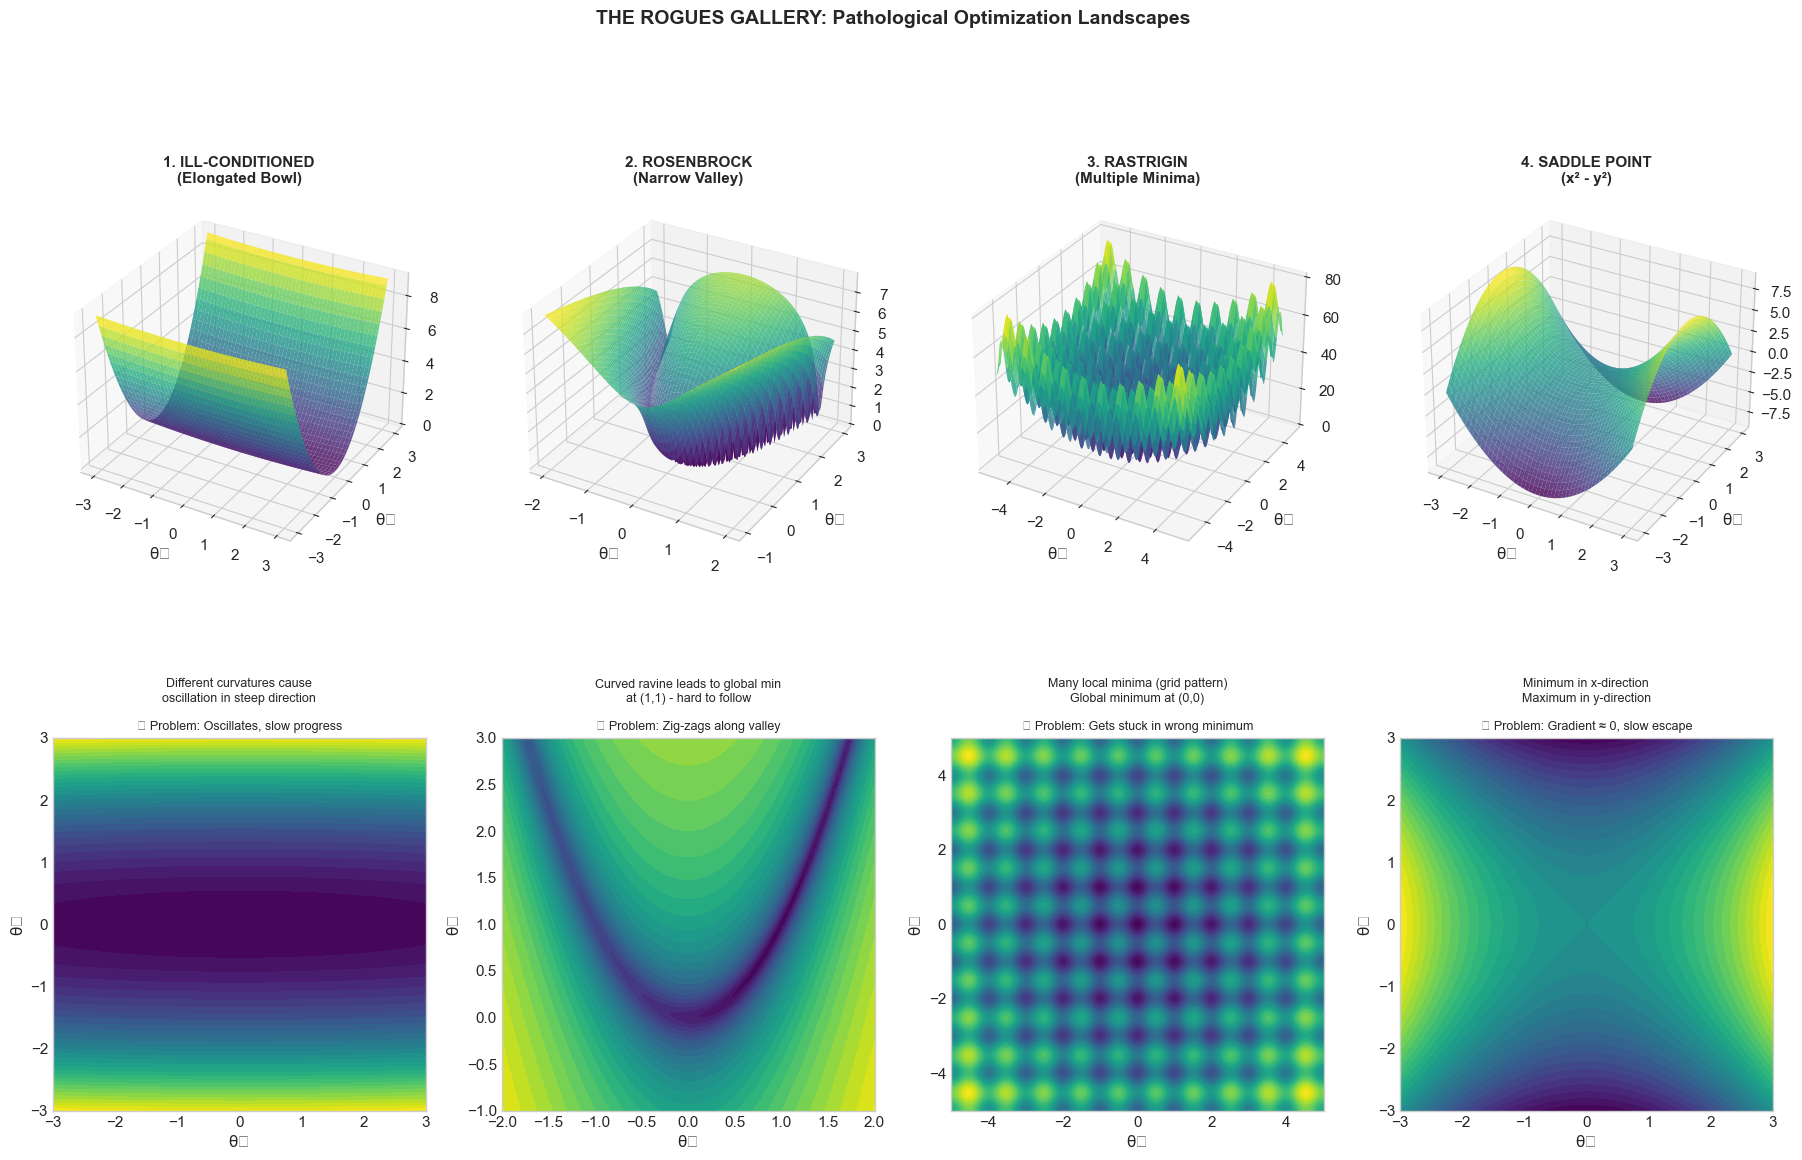

In [11]:
# ============================================================
# VISUALIZATION: Gallery of pathological surfaces
# ============================================================

fig = plt.figure(figsize=(18, 12))

# Create grids for each function
x_std = np.linspace(-3, 3, 100)
y_std = np.linspace(-3, 3, 100)
X_std, Y_std = np.meshgrid(x_std, y_std)

x_ros = np.linspace(-2, 2, 100)
y_ros = np.linspace(-1, 3, 100)
X_ros, Y_ros = np.meshgrid(x_ros, y_ros)

x_ras = np.linspace(-5, 5, 200)
y_ras = np.linspace(-5, 5, 200)
X_ras, Y_ras = np.meshgrid(x_ras, y_ras)

problems = [
    ("1. ILL-CONDITIONED\n(Elongated Bowl)", ill_conditioned(X_std, Y_std), X_std, Y_std,
     "Different curvatures cause\noscillation in steep direction", "Problem: Oscillates, slow progress"),
    
    ("2. ROSENBROCK\n(Narrow Valley)", np.log1p(rosenbrock(X_ros, Y_ros)), X_ros, Y_ros,
     "Curved ravine leads to global min\nat (1,1) - hard to follow", "Problem: Zig-zags along valley"),
    
    ("3. RASTRIGIN\n(Multiple Minima)", rastrigin(X_ras, Y_ras), X_ras, Y_ras,
     "Many local minima (grid pattern)\nGlobal minimum at (0,0)", "Problem: Gets stuck in wrong minimum"),
    
    ("4. SADDLE POINT\n(x² - y²)", saddle(X_std, Y_std), X_std, Y_std,
     "Minimum in x-direction\nMaximum in y-direction", "Problem: Gradient ≈ 0, slow escape")
]

for idx, (title, Z, Xg, Yg, description, problem) in enumerate(problems):
    # 3D surface
    ax = fig.add_subplot(2, 4, idx+1, projection='3d')
    ax.plot_surface(Xg, Yg, Z, cmap='viridis', alpha=0.8, edgecolor='none')
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.set_xlabel('θ₁')
    ax.set_ylabel('θ₂')
    
    # Contour plot
    ax2 = fig.add_subplot(2, 4, idx+5)
    if idx == 2:  # Rastrigin needs more levels
        contour = ax2.contourf(Xg, Yg, Z, levels=40, cmap='viridis')
    else:
        contour = ax2.contourf(Xg, Yg, Z, levels=30, cmap='viridis')
    ax2.set_xlabel('θ₁')
    ax2.set_ylabel('θ₂')
    ax2.set_title(f'{description}\n\n🔴 {problem}', fontsize=9)
    ax2.set_aspect('equal')

plt.suptitle('THE ROGUES GALLERY: Pathological Optimization Landscapes', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

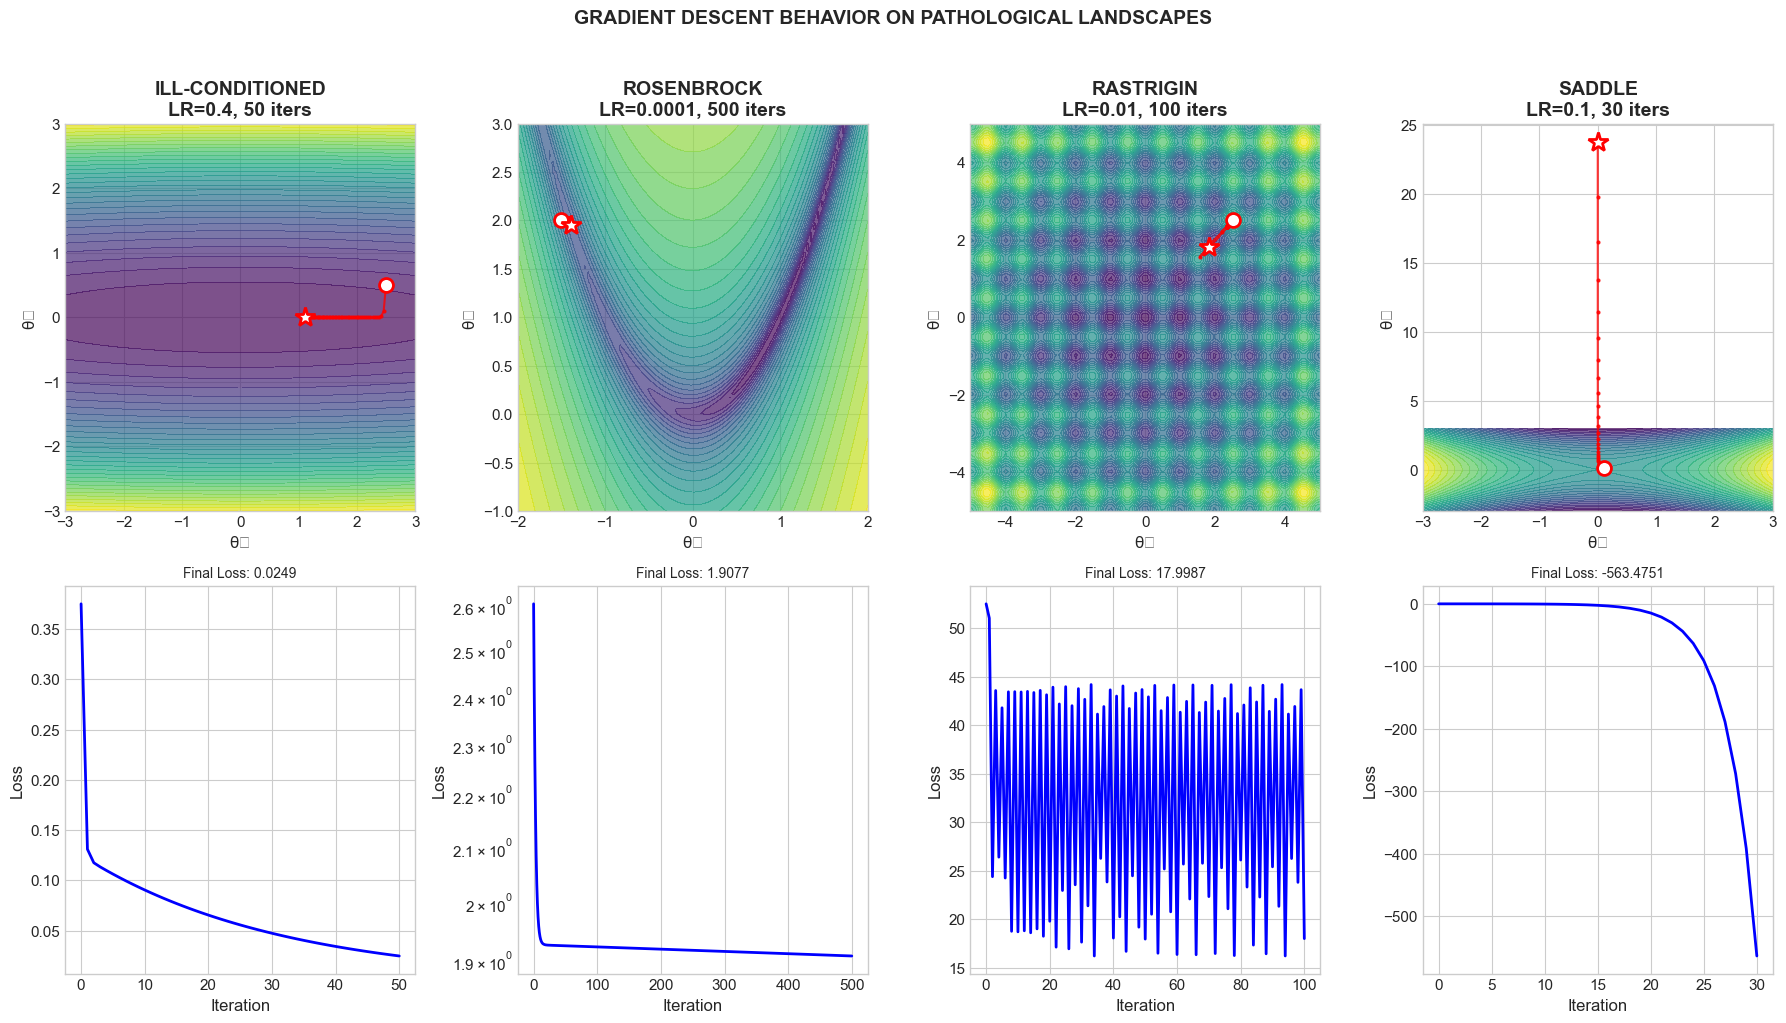


OBSERVATIONS

1. ILL-CONDITIONED: 
   → Oscillates back and forth across the narrow axis
   → Wastes iterations going sideways instead of toward minimum

2. ROSENBROCK:
   → Gets into the valley but then crawls along it VERY slowly
   → Would need 10,000+ iterations to reach (1,1)

3. RASTRIGIN:
   → Gets trapped in a LOCAL minimum (not the global at origin)
   → Where you end up depends entirely on where you start

4. SADDLE:
   → GD actually moves AWAY from the saddle point
   → But if started exactly at (0,0), gradient = 0, stuck forever



In [12]:
# ============================================================
# DEMONSTRATION: GD behavior on each pathological surface
# ============================================================

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Test cases: (name, loss_fn, grad_fn, start, lr, n_iters, xlim, ylim)
test_cases = [
    ("ILL-CONDITIONED", ill_conditioned, ill_conditioned_grad, [2.5, 0.5], 0.4, 50, (-3, 3), (-3, 3)),
    ("ROSENBROCK", lambda x,y: np.log1p(rosenbrock(x,y)), rosenbrock_grad, [-1.5, 2.0], 0.0001, 500, (-2, 2), (-1, 3)),
    ("RASTRIGIN", rastrigin, rastrigin_grad, [2.5, 2.5], 0.01, 100, (-5, 5), (-5, 5)),
    ("SADDLE", saddle, saddle_grad, [0.1, 0.1], 0.1, 30, (-3, 3), (-3, 3))
]

for idx, (name, loss_fn, grad_fn, start, lr, n_iters, xlim, ylim) in enumerate(test_cases):
    # Run GD
    history, losses = run_gradient_descent(start, loss_fn, grad_fn, lr, n_iters)
    
    # Create grid for this function
    x_grid = np.linspace(xlim[0], xlim[1], 100)
    y_grid = np.linspace(ylim[0], ylim[1], 100)
    Xg, Yg = np.meshgrid(x_grid, y_grid)
    Zg = np.zeros_like(Xg)
    for i in range(len(x_grid)):
        for j in range(len(y_grid)):
            Zg[j, i] = loss_fn(x_grid[i], y_grid[j])
    
    # Top row: Path
    ax = axes[0, idx]
    ax.contourf(Xg, Yg, Zg, levels=30, cmap='viridis', alpha=0.7)
    ax.plot(history[:, 0], history[:, 1], 'r.-', linewidth=1.5, markersize=4, alpha=0.8)
    ax.plot(history[0, 0], history[0, 1], 'wo', markersize=10, markeredgecolor='red', markeredgewidth=2)
    ax.plot(history[-1, 0], history[-1, 1], 'w*', markersize=15, markeredgecolor='red', markeredgewidth=2)
    ax.set_title(f'{name}\nLR={lr}, {n_iters} iters', fontweight='bold')
    ax.set_xlabel('θ₁')
    ax.set_ylabel('θ₂')
    
    # Bottom row: Loss curve
    ax2 = axes[1, idx]
    ax2.plot(losses, 'b-', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'Final Loss: {losses[-1]:.4f}', fontsize=10)
    if name == "ROSENBROCK":
        ax2.set_yscale('log')

plt.suptitle('GRADIENT DESCENT BEHAVIOR ON PATHOLOGICAL LANDSCAPES', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("OBSERVATIONS")
print("="*80)
print("""
1. ILL-CONDITIONED: 
   → Oscillates back and forth across the narrow axis
   → Wastes iterations going sideways instead of toward minimum

2. ROSENBROCK:
   → Gets into the valley but then crawls along it VERY slowly
   → Would need 10,000+ iterations to reach (1,1)

3. RASTRIGIN:
   → Gets trapped in a LOCAL minimum (not the global at origin)
   → Where you end up depends entirely on where you start

4. SADDLE:
   → GD actually moves AWAY from the saddle point
   → But if started exactly at (0,0), gradient = 0, stuck forever
""")

---

## 📝 Module 2 Summary

### The Landscape Taxonomy

| Landscape Type | GD Outcome | Real-World Example |
|---------------|------------|--------------------|
| **Convex** | ✅ Always finds global min | Linear/Logistic regression |
| **Ill-Conditioned** | ⚠️ Slow, oscillates | High-dimensional NNs |
| **Narrow Valley** | ⚠️ Zig-zags, slow | Deep networks |
| **Multiple Minima** | ❌ Gets stuck | Any neural network |
| **Saddle Points** | ⚠️ Slow/stuck | High-dimensional losses |

### Key Insight

> **The geometry of your loss surface determines which optimizer will work.**
> 
> This is why we need advanced optimizers like Momentum and Adam!

---

---

# Module 3: Hyperparameter Deep Dive — Learning Rate

---

The learning rate $\alpha$ is the **most important hyperparameter** in gradient descent.

## 3.1 The Learning Rate Spectrum

| Learning Rate | Behavior | Result |
|--------------|----------|--------|
| **Too small** (e.g., 0.0001) | Tiny steps | Slow convergence, may never finish |
| **Just right** | Balanced steps | Fast, stable convergence |
| **Too large** (e.g., 1.0) | Huge steps | Oscillation or divergence |
| **Way too large** (e.g., 10.0) | Explosive steps | Loss goes to infinity! |

Let's see this in action:

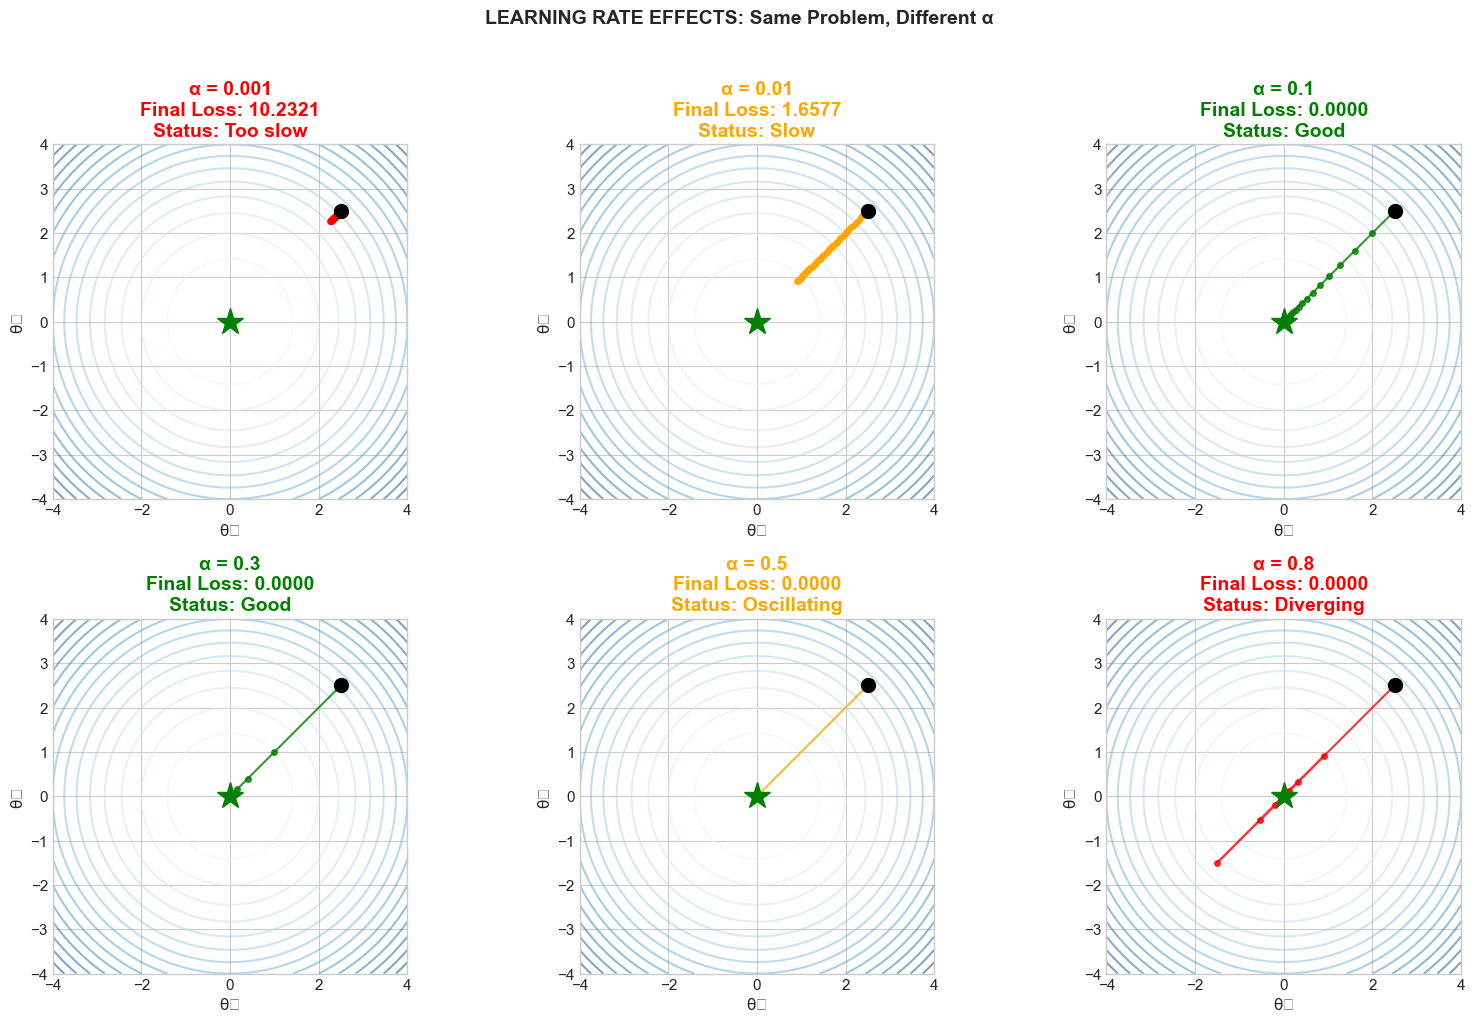

In [13]:
# ============================================================
# DEMONSTRATION: Learning rate effects
# ============================================================

def run_gd_with_tracking(start, loss_fn, grad_fn, lr, n_iters, clip_grad=None):
    """Run GD with optional gradient clipping for stability"""
    theta = np.array(start, dtype=float)
    history = [theta.copy()]
    losses = [loss_fn(theta[0], theta[1])]
    
    for _ in range(n_iters):
        grad = grad_fn(theta[0], theta[1])
        if clip_grad:
            grad = np.clip(grad, -clip_grad, clip_grad)
        theta = theta - lr * grad
        
        # Clip theta for numerical stability
        theta = np.clip(theta, -100, 100)
        
        loss = loss_fn(theta[0], theta[1])
        if np.isnan(loss) or np.isinf(loss) or loss > 1e10:
            loss = 1e10
        
        history.append(theta.copy())
        losses.append(loss)
    
    return np.array(history), np.array(losses)

# Test different learning rates
learning_rates = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8]
start_point = [2.5, 2.5]
n_iters = 50

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Create grid for contours
x_grid = np.linspace(-4, 4, 100)
y_grid = np.linspace(-4, 4, 100)
Xg, Yg = np.meshgrid(x_grid, y_grid)
Zg = simple_quadratic(Xg, Yg)

status_colors = ['red', 'orange', 'green', 'green', 'orange', 'red']
status_labels = ['Too slow', 'Slow', 'Good', 'Good', 'Oscillating', 'Diverging']

for idx, lr in enumerate(learning_rates):
    history, losses = run_gd_with_tracking(start_point, simple_quadratic, gradient_quadratic, lr, n_iters)
    
    ax = axes[idx]
    ax.contour(Xg, Yg, Zg, levels=20, cmap='Blues', alpha=0.5)
    ax.plot(history[:, 0], history[:, 1], 'o-', color=status_colors[idx], 
            linewidth=1.5, markersize=4, alpha=0.8)
    ax.plot(history[0, 0], history[0, 1], 'ko', markersize=10)
    ax.plot(0, 0, 'g*', markersize=20)
    
    final_loss = losses[-1] if losses[-1] < 1e6 else float('inf')
    ax.set_title(f'α = {lr}\nFinal Loss: {final_loss:.4f}\nStatus: {status_labels[idx]}', 
                 fontweight='bold', color=status_colors[idx])
    ax.set_xlabel('θ₁')
    ax.set_ylabel('θ₂')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')

plt.suptitle('LEARNING RATE EFFECTS: Same Problem, Different α', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

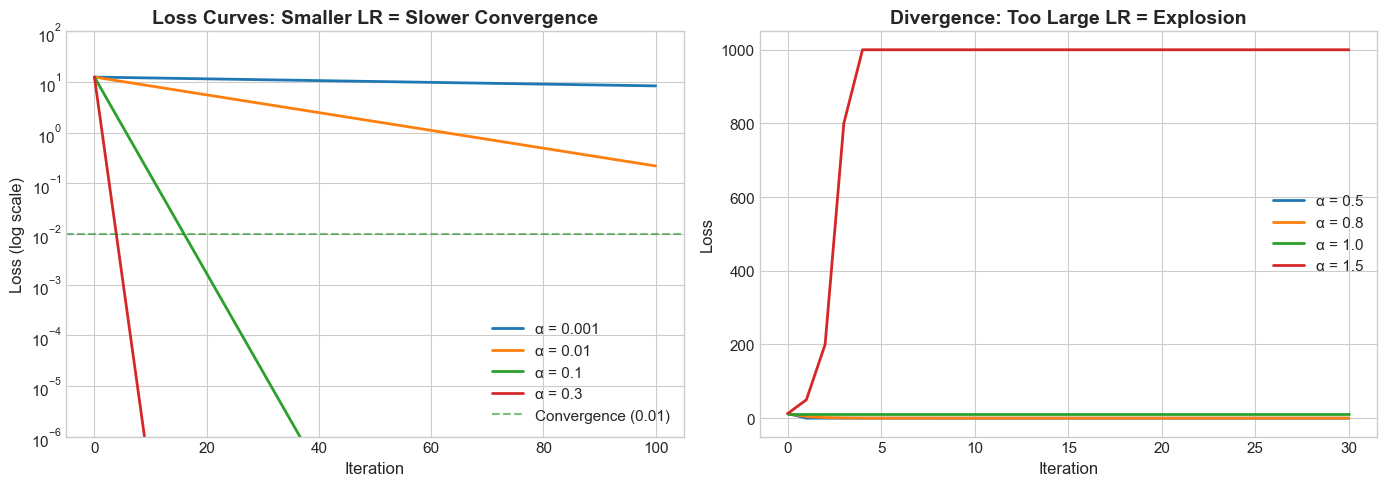


📌 THE GOLDILOCKS PRINCIPLE:
   α too small → Wastes computation, may never converge
   α too large → Overshoots, oscillates, or explodes
   α just right → Fast and stable convergence


In [14]:
# ============================================================
# VISUALIZATION: Loss curves for different learning rates
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: All loss curves
ax1 = axes[0]
for lr in [0.001, 0.01, 0.1, 0.3]:
    _, losses = run_gd_with_tracking(start_point, simple_quadratic, gradient_quadratic, lr, 100)
    ax1.semilogy(losses, linewidth=2, label=f'α = {lr}')

ax1.axhline(y=0.01, color='g', linestyle='--', alpha=0.5, label='Convergence (0.01)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss (log scale)')
ax1.set_title('Loss Curves: Smaller LR = Slower Convergence', fontweight='bold')
ax1.legend()
ax1.set_ylim(1e-6, 100)

# Right: Divergence demonstration
ax2 = axes[1]
for lr in [0.5, 0.8, 1.0, 1.5]:
    _, losses = run_gd_with_tracking(start_point, simple_quadratic, gradient_quadratic, lr, 30)
    losses = np.clip(losses, 0, 1000)
    ax2.plot(losses, linewidth=2, label=f'α = {lr}')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.set_title('Divergence: Too Large LR = Explosion', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📌 THE GOLDILOCKS PRINCIPLE:")
print("   α too small → Wastes computation, may never converge")
print("   α too large → Overshoots, oscillates, or explodes")
print("   α just right → Fast and stable convergence")

---

## 3.2 Why Does This Happen? The Math Behind It

### The Stability Condition

For a quadratic function $L(\theta) = \frac{1}{2}\theta^2$, gradient descent converges if:

$$\Large \boxed{\alpha < \frac{2}{\lambda_{max}}}$$

Where $\lambda_{max}$ is the **largest eigenvalue of the Hessian** (second derivative matrix).

### Intuition

- **Steep curvature** (large $\lambda$) → Gradient changes rapidly → Need small steps
- **Shallow curvature** (small $\lambda$) → Gradient changes slowly → Can take larger steps

### The Problem with Ill-Conditioned Functions

When eigenvalues vary greatly (e.g., $\lambda_1 = 100$, $\lambda_2 = 1$):

- LR must be small enough for the steep direction: $\alpha < 2/100 = 0.02$
- But this is too slow for the shallow direction!
- **Result**: Slow progress + oscillation

This is exactly why we need **adaptive learning rates** (coming in Module 5)!

---

## 📝 Module 3 Summary

### Learning Rate Selection Guidelines

| Scenario | Recommended Starting LR |
|----------|------------------------|
| Linear/Logistic Regression | 0.01 - 0.1 |
| Neural Networks (SGD) | 0.01 - 0.1 |
| Neural Networks (Adam) | 0.001 - 0.0001 |
| Fine-tuning pretrained | 1e-5 - 1e-4 |

### Key Takeaway

> A single learning rate is a **compromise**.
> Different parameters may need different step sizes.
> This motivates **adaptive optimizers** like Adam.

---

---

# Module 4: Batch, Mini-Batch, and Stochastic GD

---

So far we've computed gradients using **all data points at once**. But there are alternatives.

## 4.1 The Three Flavors of Gradient Descent

| Type | Data per Step | Gradient Estimate | Noise | Speed per Step |
|------|---------------|-------------------|-------|----------------|
| **Batch GD** | All N samples | Exact | None | Slow |
| **Stochastic GD (SGD)** | 1 sample | Very noisy | High | Very fast |
| **Mini-Batch GD** | B samples (e.g., 32) | Noisy | Medium | Fast |

### Why Does This Matter?

1. **Computational efficiency**: Don't need entire dataset in memory
2. **Noise as regularization**: Helps escape local minima!
3. **GPU parallelism**: Mini-batches fit well on modern hardware

In [15]:
# ============================================================
# DEMONSTRATION: Batch vs Stochastic vs Mini-Batch GD
# ============================================================

# Generate regression data
np.random.seed(42)
N = 200
X_data = np.random.randn(N)
y_data = 3 + 2*X_data + np.random.randn(N)*0.5

def mse_loss_batch(theta, X, y):
    """Full batch MSE"""
    pred = theta[0] + theta[1] * X
    return np.mean((y - pred)**2)

def gradient_batch(theta, X, y):
    """Full batch gradient"""
    pred = theta[0] + theta[1] * X
    errors = pred - y
    return np.array([2*np.mean(errors), 2*np.mean(errors * X)])

def run_batch_gd(X, y, lr, n_epochs):
    theta = np.array([0.0, 0.0])
    history = [theta.copy()]
    losses = [mse_loss_batch(theta, X, y)]
    
    for _ in range(n_epochs):
        grad = gradient_batch(theta, X, y)
        theta = theta - lr * grad
        history.append(theta.copy())
        losses.append(mse_loss_batch(theta, X, y))
    
    return np.array(history), np.array(losses)

def run_sgd(X, y, lr, n_epochs):
    theta = np.array([0.0, 0.0])
    history = [theta.copy()]
    losses = [mse_loss_batch(theta, X, y)]
    
    for epoch in range(n_epochs):
        # Shuffle data each epoch
        indices = np.random.permutation(len(X))
        for i in indices:
            # Single sample gradient
            xi, yi = X[i], y[i]
            pred = theta[0] + theta[1] * xi
            error = pred - yi
            grad = np.array([2*error, 2*error*xi])
            theta = theta - lr * grad
        
        history.append(theta.copy())
        losses.append(mse_loss_batch(theta, X, y))
    
    return np.array(history), np.array(losses)

def run_minibatch_gd(X, y, lr, n_epochs, batch_size=32):
    theta = np.array([0.0, 0.0])
    history = [theta.copy()]
    losses = [mse_loss_batch(theta, X, y)]
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X))
        for start in range(0, len(X), batch_size):
            batch_idx = indices[start:start+batch_size]
            X_batch, y_batch = X[batch_idx], y[batch_idx]
            grad = gradient_batch(theta, X_batch, y_batch)
            theta = theta - lr * grad
        
        history.append(theta.copy())
        losses.append(mse_loss_batch(theta, X, y))
    
    return np.array(history), np.array(losses)

# Run all three
n_epochs = 50

hist_batch, loss_batch = run_batch_gd(X_data, y_data, lr=0.1, n_epochs=n_epochs)
hist_sgd, loss_sgd = run_sgd(X_data, y_data, lr=0.001, n_epochs=n_epochs)
hist_mini, loss_mini = run_minibatch_gd(X_data, y_data, lr=0.05, n_epochs=n_epochs, batch_size=32)

print(f"Batch GD final loss:      {loss_batch[-1]:.6f}")
print(f"SGD final loss:           {loss_sgd[-1]:.6f}")
print(f"Mini-batch GD final loss: {loss_mini[-1]:.6f}")
print(f"\nTrue parameters: θ₀=3, θ₁=2")
print(f"Batch GD found:  θ₀={hist_batch[-1,0]:.4f}, θ₁={hist_batch[-1,1]:.4f}")
print(f"SGD found:       θ₀={hist_sgd[-1,0]:.4f}, θ₁={hist_sgd[-1,1]:.4f}")
print(f"Mini-batch found: θ₀={hist_mini[-1,0]:.4f}, θ₁={hist_mini[-1,1]:.4f}")

Batch GD final loss:      0.240133
SGD final loss:           0.240140
Mini-batch GD final loss: 0.240159

True parameters: θ₀=3, θ₁=2
Batch GD found:  θ₀=3.0449, θ₁=2.0502
SGD found:       θ₀=3.0476, θ₁=2.0500
Mini-batch found: θ₀=3.0402, θ₁=2.0481


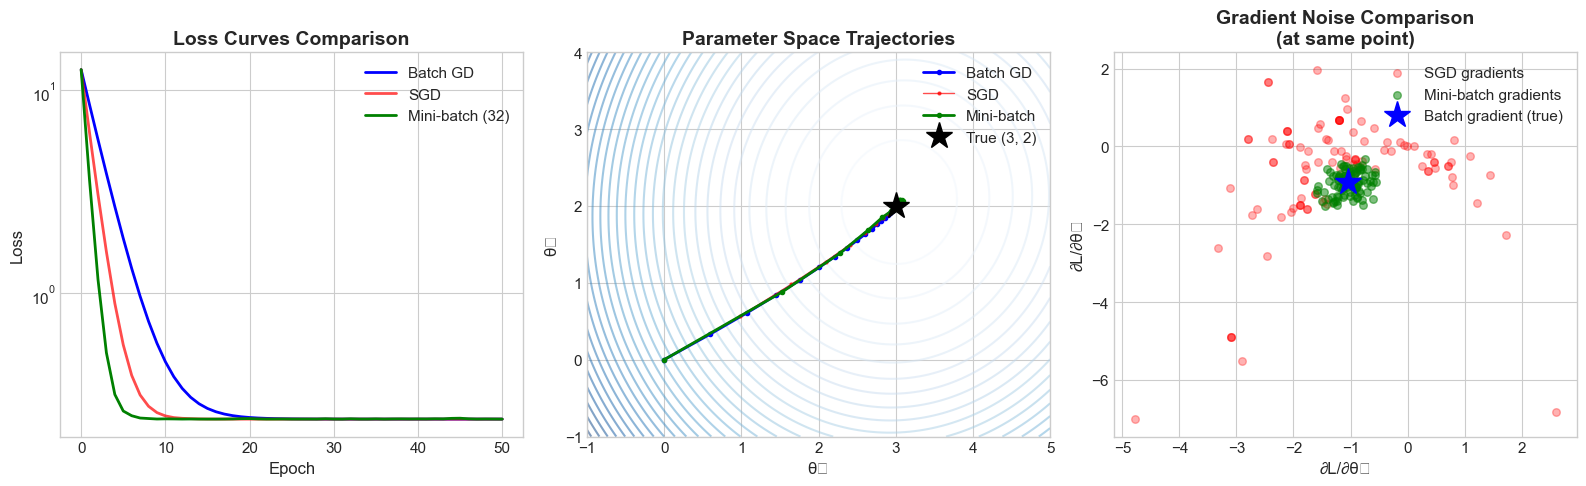


📌 KEY OBSERVATIONS:
   • Batch GD: Smooth path, exact gradients, but expensive per step
   • SGD: Noisy path (jitters around), but very fast per step
   • Mini-batch: Best of both worlds - some noise, reasonable cost


In [16]:
# ============================================================
# VISUALIZATION: Comparing the three GD variants
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Loss curves
ax1 = axes[0]
ax1.plot(loss_batch, 'b-', linewidth=2, label='Batch GD')
ax1.plot(loss_sgd, 'r-', linewidth=2, alpha=0.7, label='SGD')
ax1.plot(loss_mini, 'g-', linewidth=2, label='Mini-batch (32)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves Comparison', fontweight='bold')
ax1.legend()
ax1.set_yscale('log')

# Parameter paths - create loss surface
t0_range = np.linspace(-1, 5, 100)
t1_range = np.linspace(-1, 4, 100)
T0, T1 = np.meshgrid(t0_range, t1_range)
Z_loss = np.zeros_like(T0)
for i in range(len(t0_range)):
    for j in range(len(t1_range)):
        Z_loss[j, i] = mse_loss_batch(np.array([t0_range[i], t1_range[j]]), X_data, y_data)

ax2 = axes[1]
ax2.contour(T0, T1, Z_loss, levels=30, cmap='Blues', alpha=0.5)
ax2.plot(hist_batch[:, 0], hist_batch[:, 1], 'b.-', linewidth=2, markersize=6, label='Batch GD')
ax2.plot(hist_sgd[:, 0], hist_sgd[:, 1], 'r.-', linewidth=1, markersize=4, alpha=0.7, label='SGD')
ax2.plot(hist_mini[:, 0], hist_mini[:, 1], 'g.-', linewidth=2, markersize=6, label='Mini-batch')
ax2.plot(3, 2, 'k*', markersize=20, label='True (3, 2)')
ax2.set_xlabel('θ₀')
ax2.set_ylabel('θ₁')
ax2.set_title('Parameter Space Trajectories', fontweight='bold')
ax2.legend()

# Gradient noise visualization
ax3 = axes[2]

# Compute gradient variance for each method
theta_test = np.array([2.5, 1.5])
batch_grad = gradient_batch(theta_test, X_data, y_data)

# Sample gradients for SGD
sgd_grads = []
for i in range(100):
    idx = np.random.randint(len(X_data))
    xi, yi = X_data[idx], y_data[idx]
    pred = theta_test[0] + theta_test[1] * xi
    error = pred - yi
    sgd_grads.append([2*error, 2*error*xi])
sgd_grads = np.array(sgd_grads)

# Sample gradients for mini-batch
mini_grads = []
for _ in range(100):
    idx = np.random.choice(len(X_data), size=32, replace=False)
    grad = gradient_batch(theta_test, X_data[idx], y_data[idx])
    mini_grads.append(grad)
mini_grads = np.array(mini_grads)

ax3.scatter(sgd_grads[:, 0], sgd_grads[:, 1], alpha=0.3, c='red', s=30, label='SGD gradients')
ax3.scatter(mini_grads[:, 0], mini_grads[:, 1], alpha=0.5, c='green', s=30, label='Mini-batch gradients')
ax3.plot(batch_grad[0], batch_grad[1], 'b*', markersize=20, label='Batch gradient (true)')
ax3.set_xlabel('∂L/∂θ₀')
ax3.set_ylabel('∂L/∂θ₁')
ax3.set_title('Gradient Noise Comparison\n(at same point)', fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()

print("\n📌 KEY OBSERVATIONS:")
print("   • Batch GD: Smooth path, exact gradients, but expensive per step")
print("   • SGD: Noisy path (jitters around), but very fast per step")
print("   • Mini-batch: Best of both worlds - some noise, reasonable cost")

---

## 4.2 The Surprising Benefit of Noise

Counter-intuitively, the noise in SGD/mini-batch can be **helpful**!

### Noise Helps Escape Local Minima

| Situation | Batch GD | SGD |
|-----------|----------|-----|
| At local minimum | Gradient = 0, stuck forever | Random noise may push you out! |
| Near saddle point | Slow progress | Noise accelerates escape |
| Sharp vs flat minima | Finds any minimum | Prefers flat minima (better generalization) |

### Why Flat Minima Generalize Better

- **Sharp minimum**: Small parameter change → Big loss change → Sensitive to noise
- **Flat minimum**: Small parameter change → Small loss change → Robust to noise

SGD's noise naturally avoids sharp minima!

---

## 📝 Module 4 Summary

### When to Use Each Variant

| Variant | Best For |
|---------|----------|
| **Batch GD** | Small datasets (< 10K), convex problems, when you need exact gradients |
| **Mini-Batch GD** | **Default choice for deep learning** (batch size 32-256) |
| **SGD** | Very large datasets, when memory is extremely limited |

### The Deep Learning Standard

```python
# Typical deep learning setup
batch_size = 32  # or 64, 128, 256
for epoch in range(num_epochs):
    for batch in DataLoader(dataset, batch_size=batch_size, shuffle=True):
        loss = model(batch)
        loss.backward()
        optimizer.step()
```

---

---

# Module 5: Advanced Optimizers — The Solutions

---

Now we get to the good stuff! Each advanced optimizer was invented to solve a **specific problem** with vanilla GD.

## The Optimizer Family Tree

```
                    Vanilla GD
                        │
        ┌───────────────┼───────────────┐
        │               │               │
        ▼               ▼               ▼
    Momentum        AdaGrad        Nesterov
        │               │
        │           ┌───┴───┐
        │           │       │
        │           ▼       ▼
        │       RMSprop  AdaDelta
        │           │
        └─────┬─────┘
              │
              ▼
            Adam ◀──── The Default
              │
              ▼
           AdamW
```

Let's understand each one **mechanically**.

---

## 5.1 Momentum: Adding Inertia

### The Problem It Solves

Vanilla GD oscillates in narrow valleys because it only looks at the current gradient.

### The Idea

Imagine a ball rolling down a hill. It builds up **velocity** (momentum) and can roll through small bumps.

### The Algorithm

$$\begin{aligned}
v_t &= \beta \cdot v_{t-1} + \nabla L(\theta_{t-1}) & \text{(Accumulate velocity)} \\
\theta_t &= \theta_{t-1} - \alpha \cdot v_t & \text{(Update parameters)}
\end{aligned}$$

Where:
- $v_t$ = velocity (accumulated gradient direction)
- $\beta$ = momentum coefficient (typically 0.9)
- $\alpha$ = learning rate

In [17]:
# ============================================================
# IMPLEMENTATION: Momentum
# ============================================================

def gradient_descent_momentum(start, loss_fn, grad_fn, lr, momentum, n_iters):
    """
    Gradient Descent with Momentum
    
    v = β * v + ∇L(θ)       <- Accumulate velocity
    θ = θ - α * v           <- Update with velocity
    """
    theta = np.array(start, dtype=float)
    velocity = np.zeros_like(theta)
    
    history = [theta.copy()]
    losses = [loss_fn(theta[0], theta[1])]
    
    for _ in range(n_iters):
        grad = grad_fn(theta[0], theta[1])
        
        # Momentum update
        velocity = momentum * velocity + grad
        theta = theta - lr * velocity
        
        history.append(theta.copy())
        losses.append(loss_fn(theta[0], theta[1]))
    
    return np.array(history), np.array(losses)

# Compare vanilla GD vs Momentum on ill-conditioned problem
start = [2.5, 0.3]
n_iters = 100

hist_vanilla, loss_vanilla = run_gradient_descent(start, ill_conditioned, ill_conditioned_grad, lr=0.4, n_iters=n_iters)
hist_momentum, loss_momentum = gradient_descent_momentum(start, ill_conditioned, ill_conditioned_grad, lr=0.4, momentum=0.9, n_iters=n_iters)

print(f"Vanilla GD final loss:  {loss_vanilla[-1]:.6f}")
print(f"Momentum final loss:    {loss_momentum[-1]:.6f}")
print(f"\nMomentum is {loss_vanilla[-1]/loss_momentum[-1]:.1f}x better!")

Vanilla GD final loss:  0.004965
Momentum final loss:    0.000001

Momentum is 4886.0x better!


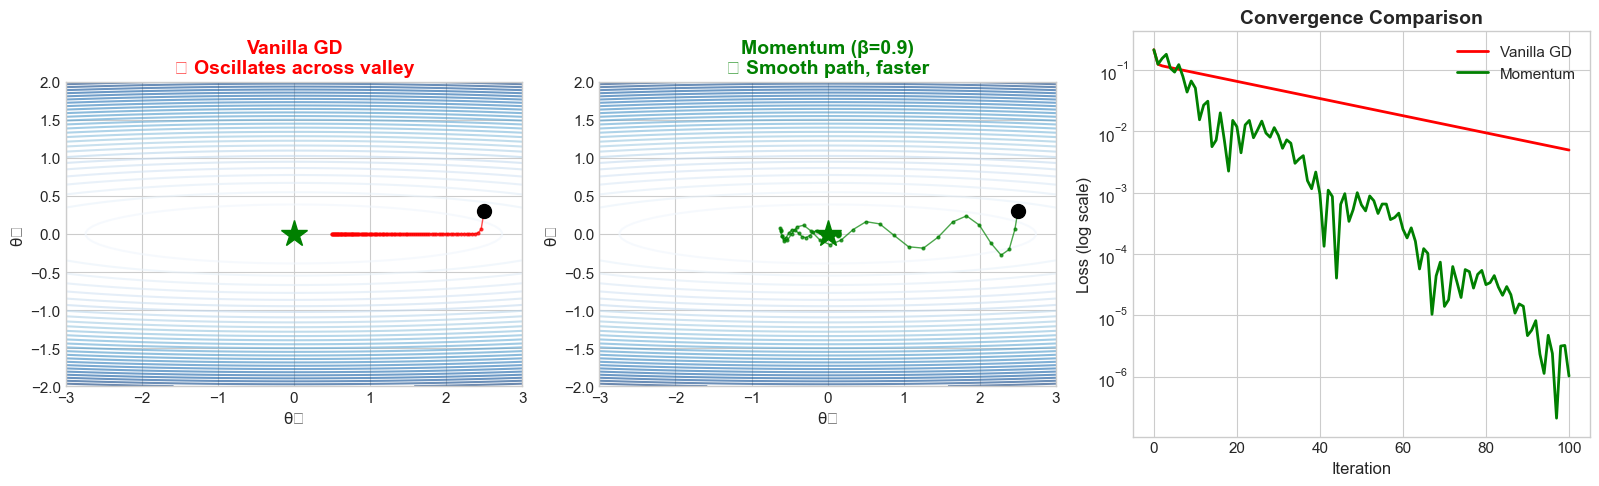


📌 WHY MOMENTUM WORKS:
   • Oscillations in y-direction cancel out (alternating gradients)
   • Progress in x-direction accumulates (consistent gradient direction)
   • Result: Damped oscillation + accelerated convergence


In [18]:
# ============================================================
# VISUALIZATION: Momentum vs Vanilla GD
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Create grid for ill-conditioned function
x_grid = np.linspace(-3, 3, 100)
y_grid = np.linspace(-2, 2, 100)
Xg, Yg = np.meshgrid(x_grid, y_grid)
Zg = ill_conditioned(Xg, Yg)

# Left: Vanilla GD path
ax1 = axes[0]
ax1.contour(Xg, Yg, Zg, levels=30, cmap='Blues', alpha=0.6)
ax1.plot(hist_vanilla[:, 0], hist_vanilla[:, 1], 'r.-', linewidth=1, markersize=4, alpha=0.7)
ax1.plot(hist_vanilla[0, 0], hist_vanilla[0, 1], 'ko', markersize=10)
ax1.plot(0, 0, 'g*', markersize=20)
ax1.set_title('Vanilla GD\n❌ Oscillates across valley', fontweight='bold', color='red')
ax1.set_xlabel('θ₁')
ax1.set_ylabel('θ₂')
ax1.set_aspect('equal')

# Middle: Momentum path
ax2 = axes[1]
ax2.contour(Xg, Yg, Zg, levels=30, cmap='Blues', alpha=0.6)
ax2.plot(hist_momentum[:, 0], hist_momentum[:, 1], 'g.-', linewidth=1, markersize=4, alpha=0.7)
ax2.plot(hist_momentum[0, 0], hist_momentum[0, 1], 'ko', markersize=10)
ax2.plot(0, 0, 'g*', markersize=20)
ax2.set_title('Momentum (β=0.9)\n✅ Smooth path, faster', fontweight='bold', color='green')
ax2.set_xlabel('θ₁')
ax2.set_ylabel('θ₂')
ax2.set_aspect('equal')

# Right: Loss comparison
ax3 = axes[2]
ax3.semilogy(loss_vanilla, 'r-', linewidth=2, label='Vanilla GD')
ax3.semilogy(loss_momentum, 'g-', linewidth=2, label='Momentum')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Loss (log scale)')
ax3.set_title('Convergence Comparison', fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()

print("\n📌 WHY MOMENTUM WORKS:")
print("   • Oscillations in y-direction cancel out (alternating gradients)")
print("   • Progress in x-direction accumulates (consistent gradient direction)")
print("   • Result: Damped oscillation + accelerated convergence")

---

## 5.2 AdaGrad: Per-Parameter Learning Rates

### The Problem It Solves

Different parameters may need different learning rates. Sparse features need larger updates.

### The Idea

Track the **sum of squared gradients** for each parameter. Reduce learning rate for frequently-updated parameters.

### The Algorithm

$$\begin{aligned}
G_t &= G_{t-1} + (\nabla L)^2 & \text{(Accumulate squared gradients)} \\
\theta_t &= \theta_{t-1} - \frac{\alpha}{\sqrt{G_t + \epsilon}} \cdot \nabla L & \text{(Adaptive update)}
\end{aligned}$$

### The Limitation

$G_t$ only grows → Learning rate decays to zero eventually!

---

## 5.3 RMSprop: Fixing AdaGrad's Decay

### The Problem It Solves

AdaGrad's learning rate decays to zero too quickly.

### The Idea

Use an **exponential moving average** of squared gradients instead of the sum.

### The Algorithm

$$\begin{aligned}
E[g^2]_t &= \beta \cdot E[g^2]_{t-1} + (1-\beta) \cdot (\nabla L)^2 & \text{(EMA of squared gradients)} \\
\theta_t &= \theta_{t-1} - \frac{\alpha}{\sqrt{E[g^2]_t + \epsilon}} \cdot \nabla L & \text{(Adaptive update)}
\end{aligned}$$

The EMA "forgets" old gradients, preventing decay to zero.

---

## 5.4 Adam: The Best of Both Worlds 🏆

### The Problem It Solves

Combines the benefits of **Momentum** (velocity) and **RMSprop** (adaptive LR).

### The Algorithm (Step by Step)

$$\begin{aligned}
m_t &= \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot \nabla L & \text{(1st moment: mean of gradients)} \\
v_t &= \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot (\nabla L)^2 & \text{(2nd moment: variance of gradients)} \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} & \text{(Bias correction for m)} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} & \text{(Bias correction for v)} \\
\theta_t &= \theta_{t-1} - \frac{\alpha \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} & \text{(Final update)}
\end{aligned}$$

### Default Hyperparameters

| Parameter | Typical Value | Role |
|-----------|---------------|------|
| $\alpha$ | 0.001 | Learning rate |
| $\beta_1$ | 0.9 | Momentum decay |
| $\beta_2$ | 0.999 | RMSprop decay |
| $\epsilon$ | 1e-8 | Numerical stability |

In [19]:
# ============================================================
# IMPLEMENTATION: Adam Optimizer
# ============================================================

def adam_optimizer(start, loss_fn, grad_fn, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, n_iters=100):
    """
    Adam: Adaptive Moment Estimation
    
    Combines:
    - Momentum (1st moment m = mean of gradients)
    - RMSprop (2nd moment v = variance of gradients)
    - Bias correction for both
    """
    theta = np.array(start, dtype=float)
    m = np.zeros_like(theta)  # 1st moment
    v = np.zeros_like(theta)  # 2nd moment
    
    history = [theta.copy()]
    losses = [loss_fn(theta[0], theta[1])]
    
    for t in range(1, n_iters + 1):
        grad = grad_fn(theta[0], theta[1])
        
        # Update biased 1st moment estimate
        m = beta1 * m + (1 - beta1) * grad
        
        # Update biased 2nd moment estimate
        v = beta2 * v + (1 - beta2) * grad**2
        
        # Bias correction
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        
        # Update parameters
        theta = theta - lr * m_hat / (np.sqrt(v_hat) + epsilon)
        
        history.append(theta.copy())
        losses.append(loss_fn(theta[0], theta[1]))
    
    return np.array(history), np.array(losses)

# Also implement RMSprop for comparison
def rmsprop_optimizer(start, loss_fn, grad_fn, lr=0.01, beta=0.9, epsilon=1e-8, n_iters=100):
    """RMSprop optimizer"""
    theta = np.array(start, dtype=float)
    v = np.zeros_like(theta)
    
    history = [theta.copy()]
    losses = [loss_fn(theta[0], theta[1])]
    
    for _ in range(n_iters):
        grad = grad_fn(theta[0], theta[1])
        v = beta * v + (1 - beta) * grad**2
        theta = theta - lr * grad / (np.sqrt(v) + epsilon)
        
        history.append(theta.copy())
        losses.append(loss_fn(theta[0], theta[1]))
    
    return np.array(history), np.array(losses)

print("✅ Adam and RMSprop implemented!")

✅ Adam and RMSprop implemented!


---

## 5.5 AdamW: Decoupled Weight Decay

### The Problem It Solves

In Adam, L2 regularization interacts strangely with adaptive learning rates.

### The Difference

| Method | Weight Decay Applied |
|--------|---------------------|
| Adam + L2 | To gradient: $g = \nabla L + \lambda\theta$ |
| AdamW | Directly to weights: $\theta = \theta - \lambda\theta$ |

### The Update

$$\theta_t = \theta_{t-1} - \alpha \left( \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \cdot \theta_{t-1} \right)$$

**When to use**: Modern transformers, LLMs, any architecture where proper regularization matters.

---

## 📝 Module 5 Summary: The Optimizer Cheat Sheet

| Optimizer | Key Innovation | When to Use | When NOT to Use |
|-----------|---------------|-------------|------------------|
| **SGD** | Simplest | Convex problems, when you want theoretical guarantees | Deep learning (usually) |
| **SGD + Momentum** | Accumulates velocity | CNNs, when you want good generalization | Sparse gradients |
| **AdaGrad** | Per-param LR | Sparse features (NLP embeddings) | Long training (LR decays) |
| **RMSprop** | EMA of squared grads | RNNs, non-stationary | When momentum would help |
| **Adam** | Momentum + RMSprop | **Default for DL**, fast convergence | When you need best generalization |
| **AdamW** | Proper weight decay | Transformers, LLMs, modern architectures | Small models |

---

---

# Module 6: Head-to-Head Comparisons

---

Theory is great, but let's see how these optimizers **actually perform** on the same problems.

## 6.1 The Grand Optimizer Race

We'll test all optimizers on:
1. **Ill-conditioned quadratic** — Tests handling of different curvatures
2. **Rosenbrock** — Tests navigation of narrow valleys
3. **Rastrigin** — Tests escape from local minima
4. **Simple quadratic** — Baseline sanity check

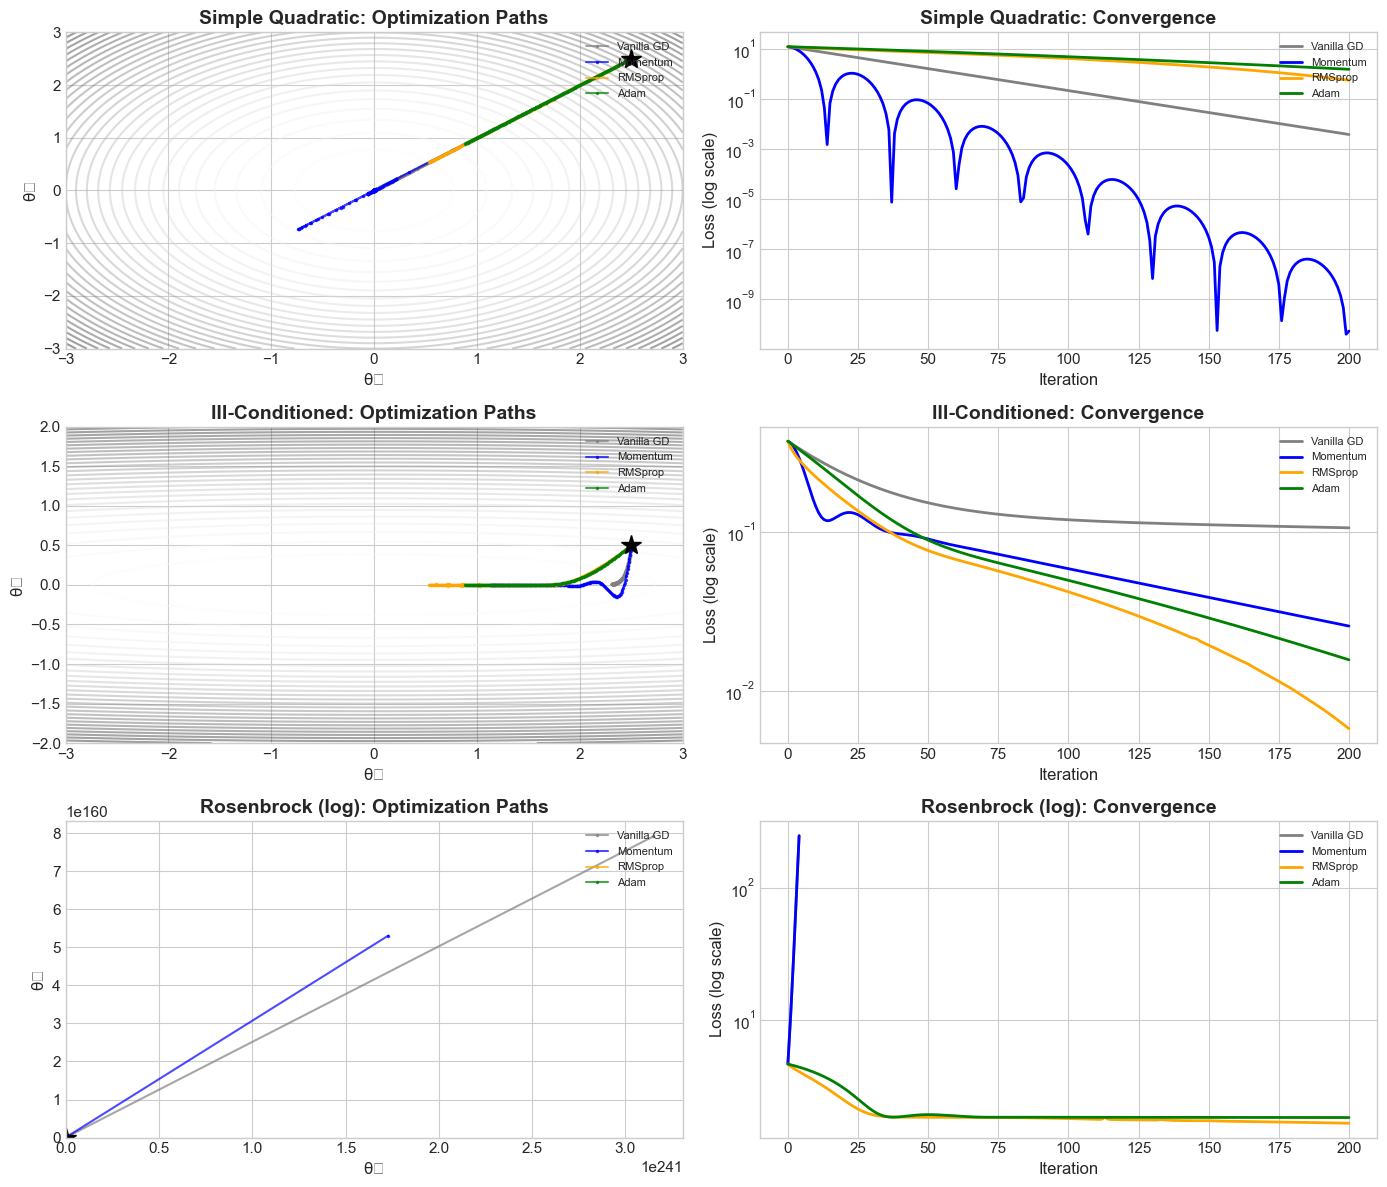

In [20]:
# ============================================================
# THE GRAND OPTIMIZER COMPARISON
# ============================================================

def run_all_optimizers(loss_fn, grad_fn, start, n_iters=200):
    """Run all optimizers and return results"""
    results = {}
    
    # Vanilla GD
    hist, losses = run_gradient_descent(start, loss_fn, grad_fn, lr=0.01, n_iters=n_iters)
    results['Vanilla GD'] = {'history': hist, 'losses': losses, 'color': 'gray'}
    
    # Momentum
    hist, losses = gradient_descent_momentum(start, loss_fn, grad_fn, lr=0.01, momentum=0.9, n_iters=n_iters)
    results['Momentum'] = {'history': hist, 'losses': losses, 'color': 'blue'}
    
    # RMSprop
    hist, losses = rmsprop_optimizer(start, loss_fn, grad_fn, lr=0.01, n_iters=n_iters)
    results['RMSprop'] = {'history': hist, 'losses': losses, 'color': 'orange'}
    
    # Adam
    hist, losses = adam_optimizer(start, loss_fn, grad_fn, lr=0.01, n_iters=n_iters)
    results['Adam'] = {'history': hist, 'losses': losses, 'color': 'green'}
    
    return results

# Test problems
test_problems = [
    ('Simple Quadratic', simple_quadratic, gradient_quadratic, [2.5, 2.5], (-3, 3), (-3, 3)),
    ('Ill-Conditioned', ill_conditioned, ill_conditioned_grad, [2.5, 0.5], (-3, 3), (-2, 2)),
    ('Rosenbrock (log)', lambda x,y: np.log1p(rosenbrock(x,y)), rosenbrock_grad, [-1.0, 2.0], (-2, 2), (-1, 3)),
]

fig, axes = plt.subplots(len(test_problems), 2, figsize=(14, 4*len(test_problems)))

for row, (name, loss_fn, grad_fn, start, xlim, ylim) in enumerate(test_problems):
    results = run_all_optimizers(loss_fn, grad_fn, start, n_iters=200)
    
    # Create contour grid
    x_grid = np.linspace(xlim[0], xlim[1], 100)
    y_grid = np.linspace(ylim[0], ylim[1], 100)
    Xg, Yg = np.meshgrid(x_grid, y_grid)
    Zg = np.zeros_like(Xg)
    for i in range(len(x_grid)):
        for j in range(len(y_grid)):
            Zg[j, i] = loss_fn(x_grid[i], y_grid[j])
    
    # Left: Paths
    ax1 = axes[row, 0]
    ax1.contour(Xg, Yg, Zg, levels=30, cmap='Greys', alpha=0.4)
    
    for opt_name, data in results.items():
        ax1.plot(data['history'][:, 0], data['history'][:, 1], 
                 '.-', color=data['color'], linewidth=1.5, markersize=3, 
                 alpha=0.7, label=opt_name)
    
    ax1.plot(start[0], start[1], 'k*', markersize=15)
    ax1.set_xlabel('θ₁')
    ax1.set_ylabel('θ₂')
    ax1.set_title(f'{name}: Optimization Paths', fontweight='bold')
    ax1.legend(loc='upper right', fontsize=8)
    
    # Right: Loss curves
    ax2 = axes[row, 1]
    for opt_name, data in results.items():
        ax2.semilogy(data['losses'], color=data['color'], linewidth=2, label=opt_name)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss (log scale)')
    ax2.set_title(f'{name}: Convergence', fontweight='bold')
    ax2.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

In [21]:
# ============================================================
# QUANTITATIVE COMPARISON
# ============================================================

print("="*90)
print("OPTIMIZER PERFORMANCE SUMMARY")
print("="*90)

for name, loss_fn, grad_fn, start, xlim, ylim in test_problems:
    print(f"\n{'─'*90}")
    print(f"Problem: {name}")
    print(f"{'─'*90}")
    print(f"{'Optimizer':<15} {'Final Loss':<15} {'Best Loss':<15} {'Iters to 1e-3':<15} {'Winner?'}")
    print(f"{'─'*90}")
    
    results = run_all_optimizers(loss_fn, grad_fn, start, n_iters=500)
    
    best_final = float('inf')
    winner = ''
    
    for opt_name, data in results.items():
        final_loss = data['losses'][-1]
        best_loss = min(data['losses'])
        
        # Find iterations to reach 1e-3
        iters_to_conv = 'Never'
        for i, loss in enumerate(data['losses']):
            if loss < 1e-3:
                iters_to_conv = str(i)
                break
        
        is_winner = ''
        if final_loss < best_final:
            best_final = final_loss
            winner = opt_name
        
        print(f"{opt_name:<15} {final_loss:<15.6f} {best_loss:<15.6f} {iters_to_conv:<15}")
    
    print(f"\n🏆 Winner: {winner}")

OPTIMIZER PERFORMANCE SUMMARY

──────────────────────────────────────────────────────────────────────────────────────────
Problem: Simple Quadratic
──────────────────────────────────────────────────────────────────────────────────────────
Optimizer       Final Loss      Best Loss       Iters to 1e-3   Winner?
──────────────────────────────────────────────────────────────────────────────────────────
Vanilla GD      0.000000        0.000000        234            
Momentum        0.000000        0.000000        37             
RMSprop         0.000050        0.000000        275            
Adam            0.009008        0.009008        Never          

🏆 Winner: Momentum

──────────────────────────────────────────────────────────────────────────────────────────
Problem: Ill-Conditioned
──────────────────────────────────────────────────────────────────────────────────────────
Optimizer       Final Loss      Best Loss       Iters to 1e-3   Winner?
──────────────────────────────────────────

---

## 📝 Module 6 Key Insights

### What We Observed

| Problem Type | Best Optimizer | Why |
|--------------|---------------|-----|
| Simple convex | All similar | Easy problem, any optimizer works |
| Ill-conditioned | Adam/RMSprop | Adaptive LR handles different curvatures |
| Narrow valley | Momentum-based | Velocity helps navigate along valley |

### General Patterns

1. **Adam is consistently good** — Rarely the worst, often the best
2. **Momentum helps with oscillation** — Smooths the path
3. **RMSprop good for varying curvature** — Adapts per-dimension
4. **Vanilla GD struggles** — Except on simple problems

---

---

# Module 7: Decision Framework

---

## 7.1 The Optimizer Decision Tree

```
                        START HERE
                            │
                            ▼
                ┌───────────────────────┐
                │ What type of problem? │
                └───────────────────────┘
                            │
          ┌─────────────────┼─────────────────┐
          │                 │                 │
          ▼                 ▼                 ▼
    ┌──────────┐      ┌──────────┐      ┌──────────┐
    │  Convex  │      │   Deep   │      │Transformer│
    │(LinReg,  │      │ Learning │      │   / LLM   │
    │ LogReg)  │      │  (CNN,   │      │           │
    │          │      │   RNN)   │      │           │
    └──────────┘      └──────────┘      └──────────┘
          │                 │                 │
          ▼                 ▼                 ▼
    ┌──────────┐      ┌──────────┐      ┌──────────┐
    │   SGD    │      │   Adam   │      │  AdamW   │
    │(or LBFGS)│      │ (default)│      │+ warmup  │
    └──────────┘      └──────────┘      └──────────┘
```

## 7.2 Quick Reference Table

| Situation | Recommended Optimizer | Learning Rate | Notes |
|-----------|----------------------|---------------|-------|
| **Linear/Logistic Regression** | SGD or L-BFGS | 0.01-0.1 | Convex, any optimizer works |
| **CNN (image classification)** | SGD + Momentum | 0.01-0.1 | Often better generalization |
| **RNN/LSTM** | Adam | 0.001 | Handles vanishing gradients |
| **Transformer** | AdamW + warmup | 1e-4 to 3e-4 | Cosine decay recommended |
| **GAN** | Adam (β₁=0.5) | 0.0002 | Lower β₁ for stability |
| **Fine-tuning pretrained** | AdamW | 1e-5 to 1e-4 | Small LR to preserve features |
| **Quick prototyping** | Adam | 0.001 | Fast, reliable default |
| **Competition/SOTA** | SGD + Momentum | Tuned | Often wins with tuning |

In [22]:
# ============================================================
# PRACTICAL EXAMPLES: How to set up optimizers in PyTorch
# ============================================================

pytorch_examples = '''
# ═══════════════════════════════════════════════════════════════
# PyTorch Optimizer Setup Examples
# ═══════════════════════════════════════════════════════════════

import torch.optim as optim

# ─────────────────────────────────────────────────────────────────
# 1. VANILLA SGD (baseline)
# ─────────────────────────────────────────────────────────────────
optimizer = optim.SGD(model.parameters(), lr=0.01)

# ─────────────────────────────────────────────────────────────────
# 2. SGD + MOMENTUM (CNNs, good generalization)
# ─────────────────────────────────────────────────────────────────
optimizer = optim.SGD(
    model.parameters(), 
    lr=0.1,           # Higher LR with momentum
    momentum=0.9,     # Standard momentum value
    weight_decay=1e-4 # L2 regularization
)

# ─────────────────────────────────────────────────────────────────
# 3. ADAM (default for most DL)
# ─────────────────────────────────────────────────────────────────
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,         # Adam typically uses smaller LR
    betas=(0.9, 0.999),
    eps=1e-8
)

# ─────────────────────────────────────────────────────────────────
# 4. ADAMW (Transformers, LLMs)
# ─────────────────────────────────────────────────────────────────
optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,          # Typical for transformers
    betas=(0.9, 0.999),
    weight_decay=0.01 # Decoupled weight decay
)

# ─────────────────────────────────────────────────────────────────
# 5. ADAMW + WARMUP (Production Transformer training)
# ─────────────────────────────────────────────────────────────────
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Warmup for first 1000 steps
warmup = LinearLR(optimizer, start_factor=0.1, total_iters=1000)
# Then cosine decay
cosine = CosineAnnealingLR(optimizer, T_max=10000)
# Combine them
scheduler = SequentialLR(optimizer, [warmup, cosine], milestones=[1000])

# In training loop:
for epoch in range(epochs):
    for batch in dataloader:
        loss = model(batch)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update LR
        optimizer.zero_grad()
'''

print(pytorch_examples)


# ═══════════════════════════════════════════════════════════════
# PyTorch Optimizer Setup Examples
# ═══════════════════════════════════════════════════════════════

import torch.optim as optim

# ─────────────────────────────────────────────────────────────────
# 1. VANILLA SGD (baseline)
# ─────────────────────────────────────────────────────────────────
optimizer = optim.SGD(model.parameters(), lr=0.01)

# ─────────────────────────────────────────────────────────────────
# 2. SGD + MOMENTUM (CNNs, good generalization)
# ─────────────────────────────────────────────────────────────────
optimizer = optim.SGD(
    model.parameters(), 
    lr=0.1,           # Higher LR with momentum
    momentum=0.9,     # Standard momentum value
    weight_decay=1e-4 # L2 regularization
)

# ─────────────────────────────────────────────────────────────────
# 3. ADAM (default for most DL)
# ─────────────────────────────────────────────────────────────────
optimizer = optim.Adam(
    model.parameters(

---

## 7.3 Common Mistakes to Avoid

| Mistake | Problem | Solution |
|---------|---------|----------|
| Using Adam LR with SGD | LR too small, slow training | SGD needs 10-100x higher LR |
| No warmup for transformers | Training instability early on | Add linear warmup for 5-10% of steps |
| Same LR for all layers | Pretrained layers change too much | Lower LR for early layers |
| Forgetting weight decay | Overfitting | Add weight_decay=0.01 for AdamW |
| Not tuning β₁ for GANs | Unstable training | Use β₁=0.5 instead of 0.9 |

---

---

# Module 8: Learning Rate Schedules

---

The learning rate doesn't have to be constant! **Scheduling** the LR during training often improves results.

## 8.1 Why Schedule the Learning Rate?

| Phase | Optimal LR | Why |
|-------|-----------|-----|
| **Early training** | Higher | Far from minimum, can take big steps |
| **Late training** | Lower | Near minimum, need precision |

## 8.2 Common Schedules

| Schedule | Formula | Use Case |
|----------|---------|----------|
| **Step decay** | Divide LR by γ every N epochs | Classic CNNs |
| **Exponential** | $\alpha_t = \alpha_0 \cdot \gamma^t$ | Smooth decay |
| **Cosine annealing** | $\alpha_t = \alpha_{min} + \frac{1}{2}(\alpha_0 - \alpha_{min})(1 + \cos(\frac{t\pi}{T}))$ | Transformers |
| **Warmup + decay** | Linear increase, then decay | LLMs, large models |
| **One-cycle** | Increase then decrease | Fast training |

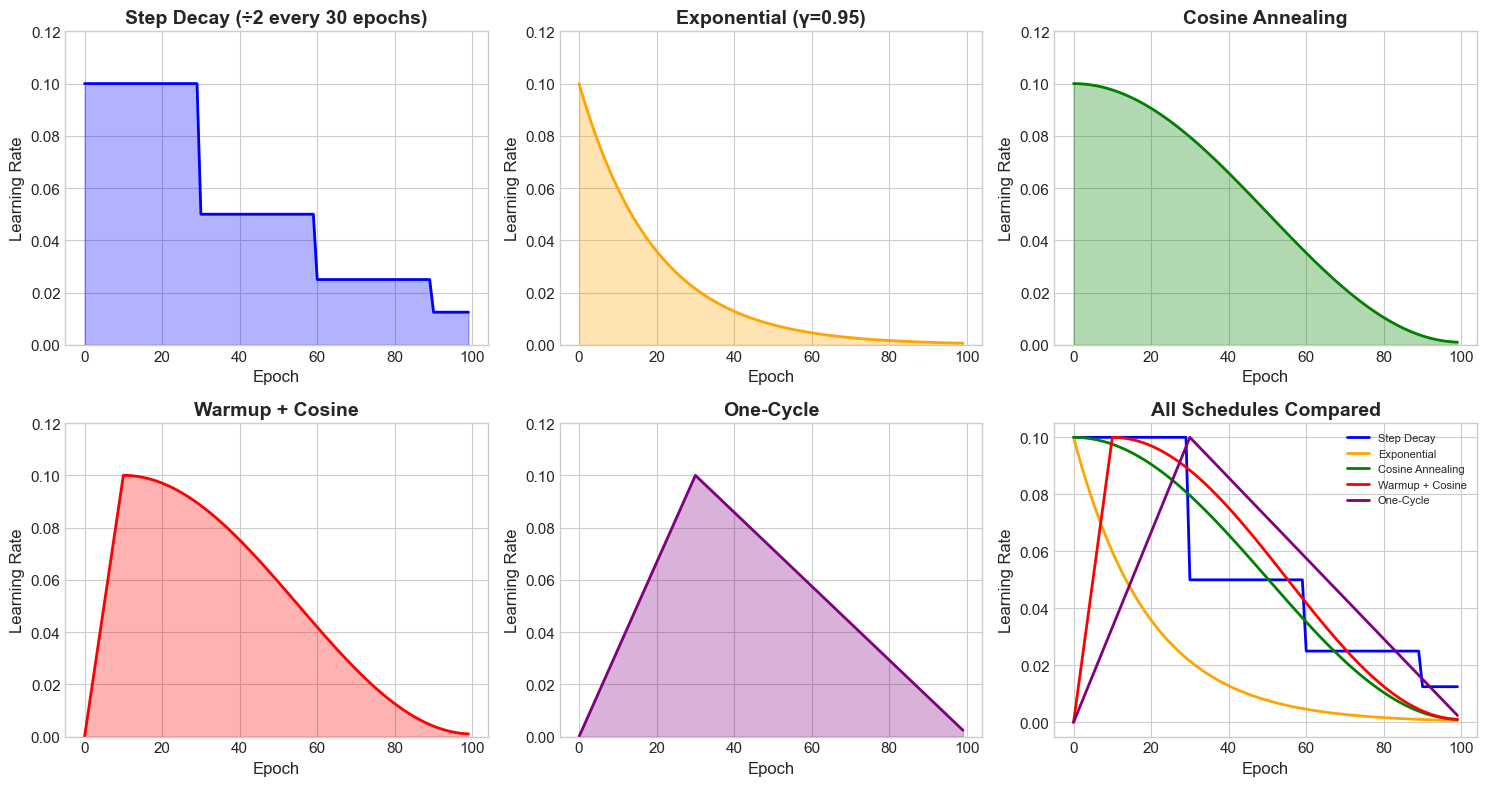

In [23]:
# ============================================================
# VISUALIZATION: Learning Rate Schedules
# ============================================================

def step_decay(epoch, initial_lr=0.1, drop=0.5, epochs_drop=30):
    return initial_lr * (drop ** (epoch // epochs_drop))

def exponential_decay(epoch, initial_lr=0.1, decay_rate=0.95):
    return initial_lr * (decay_rate ** epoch)

def cosine_annealing(epoch, initial_lr=0.1, min_lr=0.001, total_epochs=100):
    return min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(np.pi * epoch / total_epochs))

def warmup_cosine(epoch, initial_lr=0.1, min_lr=0.001, warmup_epochs=10, total_epochs=100):
    if epoch < warmup_epochs:
        return initial_lr * (epoch / warmup_epochs)
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(np.pi * progress))

def one_cycle(epoch, max_lr=0.1, total_epochs=100):
    if epoch < total_epochs * 0.3:  # Increase phase
        return max_lr * (epoch / (total_epochs * 0.3))
    else:  # Decrease phase
        progress = (epoch - total_epochs * 0.3) / (total_epochs * 0.7)
        return max_lr * (1 - progress) * 0.99 + 0.001

epochs = np.arange(100)

schedules = [
    ('Step Decay (÷2 every 30 epochs)', [step_decay(e) for e in epochs], 'blue'),
    ('Exponential (γ=0.95)', [exponential_decay(e) for e in epochs], 'orange'),
    ('Cosine Annealing', [cosine_annealing(e) for e in epochs], 'green'),
    ('Warmup + Cosine', [warmup_cosine(e) for e in epochs], 'red'),
    ('One-Cycle', [one_cycle(e) for e in epochs], 'purple'),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (name, lrs, color) in enumerate(schedules):
    ax = axes[idx]
    ax.plot(epochs, lrs, color=color, linewidth=2)
    ax.fill_between(epochs, lrs, alpha=0.3, color=color)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title(name, fontweight='bold')
    ax.set_ylim(0, 0.12)

# All together in last plot
ax = axes[5]
for name, lrs, color in schedules:
    ax.plot(epochs, lrs, color=color, linewidth=2, label=name.split('(')[0].strip())
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('All Schedules Compared', fontweight='bold')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

---

## 8.3 When to Use Which Schedule

| Model Type | Recommended Schedule | Typical Setup |
|------------|---------------------|---------------|
| **CNN (ResNet, etc.)** | Step decay or Cosine | Drop LR at epochs 30, 60, 90 |
| **Transformer** | Warmup + Cosine | 4000 step warmup, then cosine |
| **Fine-tuning** | Linear decay | Start low, decay to near-zero |
| **Quick training** | One-cycle | Fast convergence |
| **Very long training** | Cosine with restarts | Reset LR periodically |

---

---

# 🎓 Final Summary: What You've Learned

---

## The Complete Picture

| Module | Key Takeaway |
|--------|-------------|
| **1. Mechanics** | GD follows the negative gradient: $\theta = \theta - \alpha \nabla L$ |
| **2. Landscapes** | Geometry determines difficulty: convex = easy, non-convex = hard |
| **3. Learning Rate** | Too small = slow, too large = diverge, just right = fast |
| **4. Batch Types** | Mini-batch (32-256) is the practical default |
| **5. Optimizers** | Adam = good default, SGD+momentum = good generalization |
| **6. Comparisons** | No single best; depends on problem |
| **7. Decision Framework** | Match optimizer to problem type |
| **8. LR Schedules** | Warmup + cosine decay for modern training |

## Your Action Items

### For Quick Prototyping:
```python
optimizer = Adam(model.parameters(), lr=0.001)
```

### For Production Training:
```python
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps=1000, total_steps=100000)
```

### For Best Generalization:
```python
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)
```

---

## 🚀 You're Now Ready To:

1. ✅ Understand what happens in each gradient descent step
2. ✅ Diagnose optimization problems by looking at loss curves
3. ✅ Choose the right optimizer for your problem
4. ✅ Set appropriate learning rates and schedules
5. ✅ Troubleshoot training issues (oscillation, divergence, slow convergence)

---

*Happy Optimizing!* 🎯